# Capstone Project: Use of Force by IMPD

## Abstract

On May 5th, 2020 in Minneapolis, Minnesota,an African-American man named George Floyd was murdered by Derek Chauvin, a white  Minneapolis Police Officer. The events after this incident lead to world wide protests against police brutality and a push towards global police reform. On April 20, 2021, Derek Chauvin was found guilty of all charges, thus opening the gates for more successful lawsuits against police officers that misuse or abuse their power and privledge as public servants. 

The death of George Floyd is a tragic, and all too familiar story for many American Citizens of color who are caught in the cycle of systemic racism that is sadly part of the foundation of American society. The purpose of this project is to not point blame at the police, but to take a closer look at use of forces charges that uniformed officers have been charged with in order to bring more awarness to these situations and provide reasoning as to why they are occuring.

For this project I decided to work with the Indianapolis Metropolitan Police Department data because it has one of the most complete and transparent data sets on use of force data. The results were very enlightening and the XGBoost model told even more of a story than I was expecting. Overall, the XGBoost was able to account for 93% of the data, and weighed poilce units and actions even higher than race. I believe the model I produced can be used to help police and cities across America to make the proper reforms needed to ensure that many of these encounters that require use of force are reduced.

## Import packages

In [214]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import category_encoders as ce
from scipy.stats import stats

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from collections import OrderedDict

# Import functions
from charge_type import cit_charge
from cit_cond_cleaner import cit_cond
from off_cond_cleaner import off_cond
from cf_matrix import make_confusion_matrix

# Libraries for maps
import geopandas as gpd
import geopy
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import folium
from folium.plugins import FastMarkerCluster

# Import libraries for modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC
import xgboost as xgb

## Data Wrangling

The cleaning process for this dataset was very tedious. The data was very dirty and contained repetition, mislabels, and the creation of new categories was needed to better optomize the data for better model processing. I even went as far as to reach out to the Indianapolis government organization that realeases the data for clarity, and sifted through pdfs and other information in order to have a better understanding of the data that I was working with. 

### Process and Set-Up

In order to begin wrangling the data I need to import the IMPD csv file. Info on column definition can be found in the column_description.md file in the repository for this project.Be aware the the column definitions were created by me after extensive researching and exploration of the data.

In [2]:
# Import CSV
uof_df = pd.read_csv('IMPD_Use_Of_Force.csv')

# Look at the info of the CSV file
uof_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99659 entries, 0 to 99658
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   OBJECTID         99659 non-null  int64  
 1   INCNUM           99659 non-null  int64  
 2   OCCURRED_DT      99436 non-null  object 
 3   OCCURRED_TM      97956 non-null  object 
 4   UDTEXT24A        99659 non-null  object 
 5   UDTEXT24B        99659 non-null  object 
 6   UDTEXT24C        99427 non-null  object 
 7   UDTEXT24D        26716 non-null  object 
 8   DISPOSITION      94989 non-null  object 
 9   STREET_N         97329 non-null  object 
 10  STREET           97702 non-null  object 
 11  STREET_T         95797 non-null  object 
 12  STREET_G         68843 non-null  object 
 13  CITY             99097 non-null  object 
 14  UOF_FORCE_TYPE   97467 non-null  object 
 15  UOF_REASON       99547 non-null  object 
 16  SERVICE_TYPE     99559 non-null  object 
 17  CIT_ARRESTED

This data has numerous problems that need to be fixed:
* Many columns are missing data 
* Some columns need to be converted
* Certain columns can be combined
* All string columns need to be lowercased in order to create uniformity 
* Certain columns, such as OBJECTID can be dropped since they do not offer more information
* Duplicate data also needs to be removed in order to remove repetition within the data

#### Lowercasing 

First, I will lowercase all the string datatypes in order to make data wrangling and processing easier to manage. This creates a concistancy in the data and makes everything much more manageable.

In [3]:
# Lowercase all column headers
uof_df.columns = map(str.lower, uof_df.columns)

# Lowercase all elements within string columns
uof_df = uof_df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

# check to see if it worked if it worked
uof_df.head(5)

objectid  incnum occurred_dt occurred_tm            udtext24a  \
0         1   41251  2019/09/26    12:45:00  operations division   
1         2   41251  2019/09/26    12:45:00  operations division   
2         3   41251  2019/09/26    12:45:00  operations division   
3         4   41251  2019/09/26    12:45:00  operations division   
4         5   41251  2019/09/26    12:45:00  operations division   

       udtext24b     udtext24c     udtext24d    disposition street_n  ...  \
0  east district  ed day shift  ed day shift  in compliance     6204  ...   
1  east district  ed day shift  ed day shift  in compliance     6204  ...   
2  east district  ed day shift  ed day shift  in compliance     6204  ...   
3  east district  ed day shift  ed day shift  in compliance     6204  ...   
4  east district  ed day shift  ed day shift  in compliance     6204  ...   

    race   sex cit_age cit_cond_type  offnum off_race off_sex off_age  \
0  black  male    32.0           NaN  3232.0    white  female     NaN   
1  black  male    32.0           NaN  3232.0    white  female     NaN   
2  black  male    32.0           NaN  3232.0    white  female     NaN   
3  black  male    32.0           NaN  3232.0    white  female     NaN   
4  black  male    32.0           NaN  3848.0    white  female     NaN   

  off_yr_employ  off_cond_type  
0           NaN            NaN  
1           NaN            NaN  
2           NaN            NaN  
3           NaN            NaN  
4           NaN            NaN  

[5 rows x 35 columns]

#### Remove Duplicates

An issue with this dataset is that it contains duplicates of the same data. For some reason, some of the reported incidents were repeated multiple times verbadum. However, in some cases there are different charge types or multiple officers involved in the incident. In order to sort this I will do this by using the drop_duplicates method. It will first sort through incident numbers, then what the citizen was charged with, and finally sort bassed on officer badge number.

In [4]:
uof_df = uof_df.drop_duplicates(subset=['incnum', 'citcharge_type', 'offnum'])
uof_df.head(50)

objectid  incnum occurred_dt occurred_tm                   udtext24a  \
0           1   41251  2019/09/26    12:45:00         operations division   
4           5   41251  2019/09/26    12:45:00         operations division   
5           6   22933  2017/09/12    11:30:00         operations division   
6           7     166  2014/01/01    22:28:00  homeland security division   
7           8   41996  2019/10/22    05:50:00         operations division   
8           9   41996  2019/10/22    05:50:00         operations division   
9          10    5474  2014/11/09    00:52:00         operations division   
10         11   36754  2019/05/24    15:50:00         operations division   
16         17   36754  2019/05/24    15:50:00         operations division   
22         23    4269  2014/08/07    17:30:00         operations division   
23         24    4269  2014/08/07    17:30:00         operations division   
24         25    4269  2014/08/07    17:30:00         operations division   
25         26   14336  2016/05/21    18:30:00     administration division   
46         47   14336  2016/05/21    18:30:00     administration division   
61         62   41251  2019/09/26    12:45:00         operations division   
62         63   38398  2019/07/09    15:03:00         operations division   
63         64   21560  2017/06/25    02:11:00         operations division   
64         65   47821  2020/05/30    00:05:00         operations division   
65         66    4272  2014/08/08    09:08:00         operations division   
66         67    4272  2014/08/08    09:08:00         operations division   
67         68    4273  2014/08/08    09:08:00         operations division   
70         71    4408  2014/08/20    17:32:00         operations division   
72         73   30830  2018/09/23    01:30:00         operations division   
73         74   30830  2018/09/23    01:30:00         operations division   
74         75   21747  2017/07/05    16:07:00         operations division   
75         76   21747  2017/07/05    16:07:00         operations division   
77         78    4206  2014/08/01    16:30:00         operations division   
78         79    4206  2014/08/01    16:30:00         operations division   
79         80    4206  2014/08/01    16:30:00         operations division   
80         81    4378  2014/08/18    00:07:00         operations division   
81         82    4378  2014/08/18    00:07:00         operations division   
82         83    4380  2014/08/18    22:00:00         operations division   
83         84    4408  2014/08/20    17:32:00         operations division   
85         86    4497  2014/09/01    00:21:00         operations division   
86         87    4497  2014/09/01    00:21:00         operations division   
87         88    4498  2014/09/01    00:05:00         operations division   
90         91    4520  2014/09/02    16:25:00         operations division   
91         92    4520  2014/09/02    16:25:00         operations division   
92         93    4605  2014/09/04    22:05:00         operations division   
94         95    4605  2014/09/04    22:05:00         operations division   
96         97    4605  2014/09/04    22:05:00         operations division   
98         99    4640  2014/09/08    14:20:00         operations division   
102       103    4640  2014/09/08    14:20:00         operations division   
106       107    4748  2014/09/17    18:04:00         operations division   
108       109    5709  2014/11/23    03:00:00         operations division   
109       110   14524  2016/05/29    01:45:00         operations division   
110       111   10386  2015/09/27    03:30:00         operations division   
111       112   20176  2017/04/02    03:20:00         operations division   
112       113   20176  2017/04/02    03:20:00         operations division   
113       114   20176  2017/04/02    03:20:00         operations division   

                             udtext24b                 udtext24c  \
0        

As can be seen above, many rows of data were dropped, but these rows had to be dropped since they offered no new information. Keeping this information would have created a misinterpretation if my dataset, so in this case dropping these rows of data was okay.

#### Dropping columns with no significant importance

As always, certain data within this file will not be of use when running my model. Therofore, I need to remove these columns from the dataset:
* objectid - a generic value used to label the entire row entry
* cit_weapon_type - contains all NaN values. Has no useful information
* incnum - a generic value used for the incident in question. May repeat due to duplication
* offnum - a generic value used to represent the officer involved in incident
* citnum - a generic value used to represent the civilian involved in the incident 

In [5]:
# drop the unneeded colmns
uof_df = uof_df.drop(uof_df[['objectid', 'cit_weapon_type', 'incnum', 'offnum', 'citnum']], axis=1)
uof_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40744 entries, 0 to 99657
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   occurred_dt     40613 non-null  object 
 1   occurred_tm     40082 non-null  object 
 2   udtext24a       40744 non-null  object 
 3   udtext24b       40744 non-null  object 
 4   udtext24c       40628 non-null  object 
 5   udtext24d       12445 non-null  object 
 6   disposition     38380 non-null  object 
 7   street_n        39580 non-null  object 
 8   street          39755 non-null  object 
 9   street_t        38761 non-null  object 
 10  street_g        28103 non-null  object 
 11  city            40470 non-null  object 
 12  uof_force_type  38864 non-null  object 
 13  uof_reason      40668 non-null  object 
 14  service_type    40671 non-null  object 
 15  cit_arrested    40741 non-null  object 
 16  citcharge_type  38619 non-null  object 
 17  cit_injured     40736 non-null 

The data has now been setup for the cleaning process. I will begin by cleaning all data that relates to Civilians first, then Uniformed Officers, follows by Datetime and Location. 

### Civilian Data Wrangling

The following columns cover numerous categories relating to the civilians involved in the use of force incident. These columns discuss how the citizen was charged, the citizen's sex, race, age, if they were arrested, the kind of injuries that they substained and if they were injured, and possibly hospitalized.

#### Citizen Charge Type

The citizen charge type is a listing of charges placed on a civilian after the incident. When looking at the value counts I noticed that many charge types were redundant or could be placed into smaller categories. In order to stream line this process (my original process was to to look at value counts and compartmentalize the charges) I will use the function I created.

In [6]:
# Place NaN values in other crime category
uof_df['citcharge_type'] = uof_df['citcharge_type'].replace(np.NaN, 'other crime')

In [7]:
# Use function to reorganize column values
cit_charge(uof_df, uof_df['citcharge_type'])

uof_df['citcharge_type'].value_counts().head(50)

resisting arrest                       12181
assault and battery                     6589
disorderly conduct                      4276
drug possesion and use                  3851
other crime                             2125
theft                                   2005
immediate detention                     1462
trespass                                1438
vehicular crime                         1192
weapon possesion                        1134
warrant arrest                          1015
intimidation                             969
criminal mischief                        484
criminal recklessness                    482
leaving crime scene                      481
criminal confinement                     347
obstruction of justice                   224
invasion of privacy                      151
disarming a law enforcement officer       63
common nuisance                           54
murder                                    45
sex crime                                 42
violation 

The next issue to tackle is the dimensionality of the column. In order to do that, the data that makes up less than 2% will be placed in the other crime category. 

In [8]:
# Reduce dimensionality 
citcharge_type_vc = pd.value_counts(uof_df['citcharge_type'])
citcharge_type_pct = (citcharge_type_vc/citcharge_type_vc.sum() * 100).lt(2)
uof_df['citcharge_type'] = np.where(uof_df['citcharge_type'].isin(citcharge_type_vc[citcharge_type_pct].index),'other crime',uof_df['citcharge_type'])

uof_df['citcharge_type'].value_counts()

resisting arrest          12181
assault and battery        6589
other crime                4632
disorderly conduct         4276
drug possesion and use     3851
theft                      2005
immediate detention        1462
trespass                   1438
vehicular crime            1192
weapon possesion           1134
warrant arrest             1015
intimidation                969
Name: citcharge_type, dtype: int64

Now that the data is clean I can see that most civilians were charged with resisting arrest and that most altercations occured due to this charge. 

#### Citizen Race Designation

The race column consists of all the race designations that were used to classify the civilian after the use of force incident. This data contains missing values thst need to be handled.

In [9]:
# Look at race value counts
uof_df['race'].value_counts()

black          22601
white          14262
hispanic        1538
bi-racial       1435
unknown          132
asian            115
other            113
native amer       11
blace              9
b                  2
polynesian         1
Name: race, dtype: int64

The race column contains mislabels, and certain categories can be placed into a other race category in order to reduce dimentionality. In order to clean this column I will perform the following tasks:
* Recategorize NaN values and unknown vales as other
* Blace (misspelling of black) and b are obviously meant to be black designations. They will be moved to the back designation
* Since many of the other races are a small percentage as compared to black and white, these races will be placed in the other race column

In [10]:
# black racial designation adjustment
uof_df['race'] = uof_df['race'].replace('blace', 'black').replace('b', 'black')

# other racial designation adjustment
uof_df['race'] = uof_df['race'].replace('unknown', 'other').replace('native amer', 'other').replace('polynesian', 'other').replace('hispanic', 'other').replace('asian', 'other').replace('bi-racial', 'other').replace(np.NaN, 'other')

uof_df['race'].value_counts()

black    22612
white    14262
other     3870
Name: race, dtype: int64

As can be seen, civilians who are black are more likely to experience use of force by an uniformed officer than any other race.

#### Citizen Sex

Civilian sex determines whether the individual involved in the use of force encounter is male or female. This column contains missing values as well and needs to be sorted. However, I need to first take a look at the value counts in order to see if more cleaning is required.

In [11]:
uof_df['sex'].value_counts()

male       33120
female      7577
unknown       32
m              2
Name: sex, dtype: int64

I will perform the following actions in order to clean this data:
* Since male makes up the majority of the data set I will take the unknown and NaN values and combine them with the male column
* The m designation is meant to be categorized as male and will be added to that category

In [12]:
uof_df['sex'] = uof_df['sex'].replace('unknown', 'male').replace('m', 'male').replace(np.NaN, 'male')

uof_df['sex'].value_counts()

male      33167
female     7577
Name: sex, dtype: int64

#### Citizen Age

Civilian age is a listing of civilian ages. This datset has missing age values and will be handled in the following way:
* Missing ages will be replace using the median value

In [13]:
# Determine median value
median_value = uof_df.cit_age.median() #29

# Replace missing vaues with 29.0
uof_df['cit_age'] = uof_df.cit_age.fillna(median_value)

# Check to see if there are still missing values
uof_df.cit_age.isna().value_counts()

False    40744
Name: cit_age, dtype: int64

All NaN values have been filled. Now I need to convert the age column from a float to an int value.

In [14]:
# convert to int
uof_df['cit_age'] = uof_df['cit_age'].astype(np.int64)

#### Citizen Arrested?

The cit_arrested column determines if a civilian was arrested during the encounter with a label of yes for arrested and no for not arrested. I am going to perform the following fixes for this column:
* replace NaN values with the mode
* Change data type to bool, and from bool to int

In [15]:
# Check value counts
uof_df['cit_arrested'].value_counts()

yes    37860
no      2881
Name: cit_arrested, dtype: int64

In [16]:
# Replace NaN values with yes
uof_df['cit_arrested'] = uof_df['cit_arrested'].replace(np.NaN, 'yes')

# Convert to bool
a = {'yes':True, 'no': False}
uof_df['cit_arrested'] = uof_df['cit_arrested'].map(a)

# Convert to int
uof_df['cit_arrested'] = uof_df['cit_arrested'].astype(np.int64)

#### Civilian Condition After Incident

The cit_cond_type collum contains info on whether the civilian received injuries or not during the encounter and what type of injuries they sustained. In order to clean this I'm going to use my cit_cond_clean function. Afterwards, I will reduce dimensionality by placing the categories that make up a small percentage of the data into the other conditions category

In [17]:
# Replace NaN values with other
uof_df['cit_cond_type'] = uof_df['cit_cond_type'].replace(np.NaN, 'other')

In [18]:
# Use function to reorganize column values
cit_cond(uof_df, uof_df['cit_cond_type'])

uof_df['cit_cond_type'].value_counts().head(50)

no injuries noted or visible        19001
other                                5666
abrasions                            4442
complaint of pain and discomfort     3819
major and minor bleeding             2903
lacerations                          1676
canine bite                          1588
swelling and bruising                1055
chemical weapon exposure              283
taser wounds                          197
unconsciousness                        33
breathing issues                       23
weapon wound                           22
physical force wound                   15
death                                   5
handcuffing                             4
head injury                             3
abrassion                               2
pin prick middle back                   2
prior knee injury                       2
tased                                   2
soft tissue                             1
Name: cit_cond_type, dtype: int64

In [19]:
# Reduce dimensionality 
cit_cond_type_vc = pd.value_counts(uof_df['cit_cond_type'])
cit_cond_type_pct = (cit_cond_type_vc/cit_cond_type_vc.sum() * 100).lt(1)
uof_df['cit_cond_type'] = np.where(uof_df['cit_cond_type'].isin(cit_cond_type_vc[cit_cond_type_pct].index),'other',uof_df['cit_cond_type'])

uof_df['cit_cond_type'].value_counts()

no injuries noted or visible        19001
other                                6260
abrasions                            4442
complaint of pain and discomfort     3819
major and minor bleeding             2903
lacerations                          1676
canine bite                          1588
swelling and bruising                1055
Name: cit_cond_type, dtype: int64

#### Was Citizen Injured?

Citizen injured determines whether the citizen was injured during the incident. Since no injury makes up a majority of the dataset the NaN values will be replaced with no. I will then convert from a string datatype, into a bool, and then from a bool to an int in order for the data to be handled by the model later on.

In [20]:
# Look at civilian injurt values
uof_df['cit_injured'].value_counts()

no     26176
yes    14560
Name: cit_injured, dtype: int64

In [21]:
# Replace NaN values with no
uof_df['cit_injured'] = uof_df['cit_injured'].replace(np.NaN, 'no')

# Convert to bool
uof_df['cit_injured'] = uof_df['cit_injured'].map(a)

# Convert to int
uof_df['cit_injured'] = uof_df['cit_injured'].astype(np.int64)

#### Was Citizen Hospitalized?

Civilian hospitalized determines if a civilian was hospitalized after the confrontation. Since majority of the data shows that most civilians wre not hospitalized, all NaN values will be replaced with no.

In [22]:
# Let's look at civilian hospital value count
uof_df['cit_hospital'].value_counts()

no     27400
yes    13336
Name: cit_hospital, dtype: int64

In [23]:
# Replace NaN values with no
uof_df['cit_hospital'] = uof_df['cit_hospital'].replace(np.NaN, 'no')

# Convert to bool
uof_df['cit_hospital'] = uof_df['cit_hospital'].map(a)

# Convert to int
uof_df['cit_hospital'] = uof_df['cit_hospital'].astype(np.int64)

### Uniformed Officer Data Wrangling

The following set of columns contain information on the Uniformed Officers involved in the use of force scenarios. These columns need to be cleaned in order to use them in our model

#### Officer Designation

Officer designation refers to the officers role within the IMPD. This was initially difficult to figure out because the only information I had to go on was the title of the columns, which were not descriptive at all. AFter researching the IMPD and reading through the columns, I eventually pieced together that when the udtext24a through udtext24d were combined into one column that these four columns were providing me with the officers designation within the IMPD. I did the following in order to create one column for officer designation.

In [24]:
# Replace NaN values in udtext24c through udtext24d with '' since position does not exist
uof_df['udtext24c'] = uof_df['udtext24c'].replace(np.NaN, '')

uof_df['udtext24d'] = uof_df['udtext24d'].replace(np.NaN, '')

In [25]:
# Combine all four udtext24 into one designation column for officers
uof_df["uo_designation"] = uof_df.filter(like='udtext24').astype(str).apply(' '.join, 1)

uof_df["uo_designation"] 

0        operations division east district ed day shift...
4        operations division east district ed day shift...
5        operations division southwest district sw day ...
6        homeland security division homeland security b...
7        operations division northwest district nw day ...
                               ...                        
99649    operations division northwest district nw midd...
99650     operations division east district ed late shift 
99651     operations division east district ed late shift 
99655     operations division east district ed late shift 
99657     operations division east district ed late shift 
Name: uo_designation, Length: 40744, dtype: object

In [26]:
# Remove repeating designation terms
uof_df["uo_designation"] = (uof_df["uo_designation"] .str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))

uof_df["uo_designation"][6]

'homeland security division bureau/tactical canine section unit - late tactical'

#### Officer Disposition

Officer disposition was another difficult column to understand. I eneded up figuring it out after discovering a pdf about how the IMPD deals with officers who are suspected or accused of misconduct. The disposition, in actuality, explains whether the complaint against the officer proceeded or was dropped. Since in compliance is majority of the cases, I will move the other categories to other.

In [27]:
# Look at value counts in disposition and replace NaN values with other
uof_df['disposition'] = uof_df['disposition'].replace(np.NaN, 'other')

uof_df['disposition'].value_counts()

in compliance             38279
other                      2364
not in compliance            70
inactive                     14
finalized                    12
entry completed               3
f.c. converted to c.c.        2
Name: disposition, dtype: int64

In [28]:
# Reduce dimensionality 
off_disp_vc = pd.value_counts(uof_df['disposition'])
off_disp_pct = (off_disp_vc/off_disp_vc.sum() * 100).lt(2)
uof_df['disposition'] = np.where(uof_df['disposition'].isin(off_disp_vc[off_disp_pct].index),'other',uof_df['disposition'])

uof_df['disposition'].value_counts()

in compliance    38279
other             2465
Name: disposition, dtype: int64

#### Officer Race

Loos at the races of the officers involved in these situations. Since the value counts show that majority of these confrontations are by white officers. To reduce dimensionality in this dataset, hispanic, other and asian were moved to an other column since they made up a small percentage of the dataset.

In [29]:
# look at off_race value counts
uof_df['off_race'].value_counts()

white       33656
black        4565
hispanic     1733
other         478
asian          56
Name: off_race, dtype: int64

In [30]:
# categorize NaN values as other
uof_df['off_race'] = uof_df['off_race'].replace(np.NaN, 'other').replace('hispanic', 'other').replace('asian', 'other')

uof_df['off_race'].value_counts()

white    33656
black     4565
other     2523
Name: off_race, dtype: int64

#### Officer Sex

This column contains informatio on the sex of the officers invlved in these incidents. Majority of these incidents involved male officers. In order to properly clean this data we will replace all NaN values with male.

In [31]:
# Since male makes up the majority of the data I will add NaN values to male category
uof_df['off_sex'] = uof_df['off_sex'].replace(np.NaN, 'male')

uof_df['off_sex'].value_counts()

male      36854
female     3890
Name: off_sex, dtype: int64

#### Officer Age

This dataset refers to the age of the officers. In order to simplfy things, the median value was used to fill the missing values. This column was then converted to an int for modeling.

In [32]:
# Determine median value
off_median_value = uof_df.off_age.median() 
off_median_value

34.0

In [33]:
# Replace missing vaues with 34.0
uof_df['off_age'] = uof_df.off_age.fillna(off_median_value)

# Check to see if there are still missing values
uof_df.off_age.isna().value_counts()

False    40744
Name: off_age, dtype: int64

In [34]:
# convert to int
uof_df['off_age'] = uof_df['off_age'].astype(np.int64)

#### Officer Years of Employment

This dataset contains information on how many years an officer was employed by the IMPD. The median value was used to replace the missing values and the column was then changed to an int datatype.

In [35]:
# Determine median value
emp_median_value = uof_df.off_yr_employ.median() 
emp_median_value

7.0

In [36]:
# Replace missing vaues with 34.0
uof_df['off_yr_employ'] = uof_df.off_yr_employ.fillna(emp_median_value)

# Check to see if there are still missing values
uof_df.off_yr_employ.isna().value_counts()

False    40744
Name: off_yr_employ, dtype: int64

In [37]:
# Convert to int
uof_df['off_yr_employ'] = uof_df['off_yr_employ'].astype(np.int64)

#### Officer Condition After Incident

This dataset determines the officers condition after the incident. All NaN values were replaced with other and then all similar conditions were grouped into the same categories. Dimensionality was then reduced.

In [38]:
# Replace NaN values with other 
uof_df['off_cond_type'] = uof_df['off_cond_type'].replace(np.NaN, 'other')

In [39]:
# Use function to recategorize condition types
off_cond(uof_df, uof_df['off_cond_type'])

uof_df['off_cond_type'].value_counts().head(50)

no injuries noted or visible    21953
other                           13155
complaint of pain                2360
abrasions                        1224
swelling and bruising             832
major and minor bleeding          503
lacerations                       425
physical assault                  168
exposure to bodily fluids          63
muscular injury                    38
weapon wound                        9
stirke to the neck                  5
concussion                          3
cervical disc compression           3
blood on cheek                      2
blood exsposure to hep c            1
Name: off_cond_type, dtype: int64

In [40]:
# Reduce dimensionality 
off_cond_type_vc = pd.value_counts(uof_df['off_cond_type'])
off_cond_type_pct = (off_cond_type_vc/off_cond_type_vc.sum() * 100).lt(1)
uof_df['off_cond_type'] = np.where(uof_df['off_cond_type'].isin(off_cond_type_vc[off_cond_type_pct].index),'other',uof_df['off_cond_type'])

uof_df['off_cond_type'].value_counts()

no injuries noted or visible    21953
other                           13447
complaint of pain                2360
abrasions                        1224
swelling and bruising             832
major and minor bleeding          503
lacerations                       425
Name: off_cond_type, dtype: int64

#### Officer Injured

Officer injured determines if an officer was hurt during these incidents. Since majority of the values are no, I will replace NaN values with no and then finally convert the column to an int datatype.

In [41]:
#Replace NaN values with no values
uof_df['off_injured'] = uof_df['off_injured'].replace(np.NaN, 'no')

# Convert to bool
uof_df['off_injured'] = uof_df['off_injured'].map(a)

# Convert to int
uof_df['off_injured'] = uof_df['off_injured'].astype(np.int64)

#### Officer Hospitalized

Determines if officer was hospitalized during incident. Since officers were normally not hospitalized, the NaN values were replaced with no. This columns data type was then converted to int.

In [42]:
uof_df['off_hospital'] = uof_df['off_hospital'].replace(np.NaN, 'no')

# Convert to bool
uof_df['off_hospital'] = uof_df['off_hospital'].map(a)

# Convert to int
uof_df['off_hospital'] = uof_df['off_hospital'].astype(np.int64)

### Use of Force

#### Use of Force

The use of force column determines the type of force the officer used on the civilian. Since the IMPD categorizes force as physical, less lethal, and lethal, I had to use their information pertaining to tactics and weapons used by officers in order to properly categorize these into three categories. All NaN values were then replaced with the physical category.

In [43]:
# Organize physical force methods into physical force types
uof_df['uof_force_type'] = uof_df['uof_force_type'].replace('physical-weight leverage', 'physical').replace('physical-handcuffing', 'physical').replace('physical-take down', 'physical').replace('physical-other', 'physical').replace('physical-joint/pressure', 'physical').replace('physical-leg sweep', 'physical').replace('canine bite', 'physical').replace('physical-knee strike', 'physical').replace('physical-fist strike', 'physical').replace('physical-palm strike', 'physical').replace('physical-kick', 'physical').replace('hands, fist, feet', 'physical').replace('physical-elbow strike', 'physical').replace('body weight leverage', 'physical').replace('handcuffing', 'physical').replace('joint manipulation', 'physical').replace('physical-push', 'physical').replace('physical-push', 'physical')
uof_df['uof_force_type'].value_counts()

physical                   31716
less lethal-taser           3545
lethal-handgun              1078
less lethal-cs/oc           1039
taser                        275
less lethal-bean bag         203
less lethal-pepperball       181
less lethal-other            141
less lethal-baton            141
less lethal-cs fogger        123
less lethal-burning cs       120
personal cs/oc spray          53
less lethal-bps gas           52
pointing a firearm            45
lethal-rifle                  41
less lethal-clearout oc       41
less lethal-cs grenade        20
lethal-vehicle                14
less lethal-flash bang        12
lethal-shotgun                 8
baton                          6
pepper ball                    4
bean bag                       3
other impact weapon            2
cs fogger                      1
Name: uof_force_type, dtype: int64

In [44]:
# Organize less lethal force methods into less lethal force types
uof_df['uof_force_type'] = uof_df['uof_force_type'].replace('less lethal-taser', 'less lethal').replace('less lethal-cs/oc', 'less lethal').replace('taser', 'less lethal').replace('less lethal-bean bag', 'less lethal').replace('less lethal-pepperball', 'less lethal').replace('less lethal-baton', 'less lethal').replace('less lethal-other', 'less lethal').replace('less lethal-cs fogger', 'less lethal').replace('less lethal-burning cs', 'less lethal').replace('personal cs/oc spray', 'less lethal').replace('less lethal-bps gas', 'less lethal').replace('less lethal-clearout oc', 'less lethal').replace('less lethal-cs grenade', 'less lethal').replace('less lethal-flash bang', 'less lethal').replace('baton', 'less lethal').replace('pepper ball', 'less lethal').replace('bean bag', 'less lethal').replace('other impact weapon', 'less lethal').replace('cs fogger', 'less lethal')
uof_df['uof_force_type'].value_counts()

physical              31716
less lethal            5962
lethal-handgun         1078
pointing a firearm       45
lethal-rifle             41
lethal-vehicle           14
lethal-shotgun            8
Name: uof_force_type, dtype: int64

In [45]:
# Organize lethal force methods into lethal force types
uof_df['uof_force_type'] = uof_df['uof_force_type'].replace('lethal-handgun', 'lethal').replace('pointing a firearm', 'lethal').replace('lethal-rifle', 'lethal').replace('lethal-vehicle', 'lethal').replace('lethal-shotgun', 'lethal')
uof_df['uof_force_type'].value_counts()

physical       31716
less lethal     5962
lethal          1186
Name: uof_force_type, dtype: int64

In [46]:
# Replace NaN values with physical
uof_df['uof_force_type'] = uof_df['uof_force_type'].replace(np.NaN, 'physical')
uof_df['uof_force_type'].value_counts()

physical       33596
less lethal     5962
lethal          1186
Name: uof_force_type, dtype: int64

#### Use of Force Reason

This column provides reasoning as to why the type of use of force was used during the incident by the officer. Resisting arrest was normally the reason for use of force by an officer so all NaN values were replaced with resisting arrest. Dimensionality was then reduced.

In [47]:
uof_df['uof_reason'] = uof_df['uof_reason'].replace(np.NaN, 'resisting_arrest')

In [48]:
uof_rea_vc = pd.value_counts(uof_df['uof_reason'])
uof_rea_pct = (uof_rea_vc/uof_rea_vc.sum() * 100).lt(2)
uof_df['uof_reason'] = np.where(uof_df['uof_reason'].isin(uof_rea_vc[uof_rea_pct].index),'other',uof_df['uof_reason'])

uof_df['uof_reason'].value_counts()

resisting arrest            16439
non-compliant                8697
combative suspect            6176
fleeing                      3891
assaulting officer(s)        3406
felony stop/apprehension     1012
assaulting citizen(s)         929
other                         194
Name: uof_reason, dtype: int64

#### Service Type

Service Type refers to the type of incident the officers were respnding too. Majority of the incients were categorized under arrest and missing values were placed under this category. Dimensionality was reduced.

In [49]:
# Replace NaN values with arrest
uof_df['service_type'] = uof_df['service_type'].replace(np.NaN, 'arrest')

# Replace search warrant with warrant service in order to add to element
uof_df['service_type'] = uof_df['service_type'].replace('search warrant', 'warrant service')

# assisting another agency with assisting another agency to add to element
uof_df['service_type'] = uof_df['service_type'].replace('assisting another agency', 'assisting other agency')

uof_df['service_type'].value_counts()

arrest                     22533
call for service            8162
investigation               3039
traffic stop                2174
request for psd              817
warrant service              794
off-duty employment          677
assisting a citizen          634
swat incident                607
self-initiated activity      544
assisting other agency       468
erg incident                 229
not applicable                66
Name: service_type, dtype: int64

In [50]:
ser_vc = pd.value_counts(uof_df['service_type'])
ser_pct = (ser_vc/ser_vc.sum() * 100).lt(1)
uof_df['service_type'] = np.where(uof_df['service_type'].isin(ser_vc[ser_pct].index),'other',uof_df['service_type'])

uof_df['service_type'].value_counts()

arrest                     22533
call for service            8162
investigation               3039
traffic stop                2174
request for psd              817
warrant service              794
off-duty employment          677
assisting a citizen          634
swat incident                607
self-initiated activity      544
assisting other agency       468
other                        295
Name: service_type, dtype: int64

### Datetime Wrangling

Datetime can be a very significant piece of information. It can tell me where and when an incident takes place, which could lead to a possible correlation between Police Brutality and time of year. In this dataset there are two datetime keeping columns. However, there are two issues:
* They are both the wrong data type
* They should also be merged into one column

I will do that now

In [51]:
# Combine occured_dt and occured_tm datetime columns and transform new datetime column into a datetime datatype

uof_df['datetime'] = pd.to_datetime(uof_df['occurred_dt']+' '+uof_df['occurred_tm'])

uof_df['datetime'].head()

0   2019-09-26 12:45:00
4   2019-09-26 12:45:00
5   2017-09-12 11:30:00
6   2014-01-01 22:28:00
7   2019-10-22 05:50:00
Name: datetime, dtype: datetime64[ns]

However, there is an issue here. I can't replace my NaN values using interpolating since there is no realtionship between date and incident. Instead, I will create two new columns that look at incidents per year, month, and day. The NaN values will be sorted using a groupby method.

In [52]:
# Let's drop occurred_dt and occurred_tm from the dataframe
uof_df = uof_df.drop(uof_df[['occurred_dt', 'occurred_tm']], axis=1)

In [53]:
# Create a new column for weekday
uof_df['occurred_wd'] = uof_df['datetime'].dt.day_name()

uof_df['occurred_wd']

0         Thursday
4         Thursday
5          Tuesday
6        Wednesday
7          Tuesday
           ...    
99649     Thursday
99650     Thursday
99651     Thursday
99655     Thursday
99657     Thursday
Name: occurred_wd, Length: 40744, dtype: object

In [54]:
# Put missing values in an other column
uof_df['occurred_wd'] = uof_df['occurred_wd'].replace(np.NaN, 'other')
uof_df['occurred_wd'].value_counts()

Sunday       6407
Saturday     6253
Friday       5752
Wednesday    5729
Tuesday      5436
Thursday     5279
Monday       5127
other         761
Name: occurred_wd, dtype: int64

In [55]:
# Create a new column for month
uof_df['occurred_month'] = uof_df['datetime'].dt.month_name()

uof_df['occurred_month'].head() 

0    September
4    September
5    September
6      January
7      October
Name: occurred_month, dtype: object

In [56]:
# Replace missing values with Other
uof_df['occurred_month'] = uof_df['occurred_month'].replace(np.NaN, 'other')
uof_df['occurred_month'].value_counts()

November     3758
October      3745
August       3715
December     3605
May          3445
September    3439
February     3431
March        3272
January      3156
July         3130
April        2750
June         2537
other         761
Name: occurred_month, dtype: int64

In [57]:
#Drop datetime from Dataset since it holds no importance anymore
uof_df = uof_df.drop(uof_df[['datetime']], axis=1)

### Incident Location

Incident location determines where the incident occurred. Majority were Indianapolis, but this datset rquired a ot of cleaning since Indianapolis contained a lot of misspellings. Afterwards, missing addresses were dropped from the dataset (These rows also contained numerous missing values that couldn't be accounted for). Finally an entirely new column was created called address which combined the street_n, street_g, street, street_t and city information into one column which provided the complete address. After the addresses were determines, they were then used to get the latitude and longitudinal coordinates of the data.

In [58]:
# Replace NaN values with Indianapolis
uof_df['city'] = uof_df['city'].replace(np.NaN, 'indianapolis')

# Correct mispellings or shortenings of Indianapolis
uof_df.loc[uof_df['city'].str.contains('ind|ini|inp|in|id'), 'city'] = 'indianapolis'

uof_df['city'].value_counts()

indianapolis    40561
beech grove        41
speedway           23
camby              23
moorseville        18
clermont           15
southport          15
cumberland         10
lawrence            8
lebanon             5
fishers             4
homecroft           4
greenfield          3
lapel               2
whiteland           2
greenwood           2
nora                2
west newton         2
mobile              1
rocky ripple        1
carmel              1
danville            1
Name: city, dtype: int64

In [59]:
# If the street was missing from the dataset, then that row was dropped
uof_df = uof_df.dropna(how='any', subset=['street'])

In [60]:
# Create address column
uof_df['address'] = uof_df["street_n"].map(str) + " " + \
uof_df["street_g"].map(str) + " " + \
uof_df["street"].map(str) + " " + \
uof_df["street_t"].map(str) + " " + \
uof_df["city"] + " " + 'indiana'

uof_df['address']

0           6204 nan commodore street indianapolis indiana
4           6204 nan commodore street indianapolis indiana
5            2920 nan campanile drive indianapolis indiana
6                   615 w 29th street indianapolis indiana
7                  1416 w 27th street indianapolis indiana
                               ...                        
99608              50 n franklin road indianapolis indiana
99610              50 n franklin road indianapolis indiana
99612              50 n franklin road indianapolis indiana
99629    8300 s interstate 65 highway indianapolis indiana
99630                 101.6 n i65 nan indianapolis indiana
Name: address, Length: 39755, dtype: object

In [61]:
# Remove and NaN labels within the address itself
uof_df["address"].replace("nan", "", inplace=True, regex=True)

uof_df['address']

0              6204  commodore street indianapolis indiana
4              6204  commodore street indianapolis indiana
5               2920  campanile drive indianapolis indiana
6                   615 w 29th street indianapolis indiana
7                  1416 w 27th street indianapolis indiana
                               ...                        
99608              50 n franklin road indianapolis indiana
99610              50 n franklin road indianapolis indiana
99612              50 n franklin road indianapolis indiana
99629    8300 s interstate 65 highway indianapolis indiana
99630                    101.6 n i65  indianapolis indiana
Name: address, Length: 39755, dtype: object

In [62]:
# Remove Street and city columns since they have been used to create adress column

uof_df = uof_df.drop(uof_df[["street_n", "street", "street_t", "street_g", "city"]], axis=1)

uof_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39755 entries, 0 to 99630
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   udtext24a       39755 non-null  object
 1   udtext24b       39755 non-null  object
 2   udtext24c       39755 non-null  object
 3   udtext24d       39755 non-null  object
 4   disposition     39755 non-null  object
 5   uof_force_type  39755 non-null  object
 6   uof_reason      39755 non-null  object
 7   service_type    39755 non-null  object
 8   cit_arrested    39755 non-null  int64 
 9   citcharge_type  39755 non-null  object
 10  cit_injured     39755 non-null  int64 
 11  cit_hospital    39755 non-null  int64 
 12  off_injured     39755 non-null  int64 
 13  off_hospital    39755 non-null  int64 
 14  race            39755 non-null  object
 15  sex             39755 non-null  object
 16  cit_age         39755 non-null  int64 
 17  cit_cond_type   39755 non-null  object
 18  off_ra

Now that I have the addresses, I used geoencoding to get the latitude and longitude of these locations. This was a very tedious process and I will not be showing the entire process of this notebook, but I will explain throughout this section.

In order to determine these addresses lats and longs, I used the geoencoding library. The geoencoding library basically runs the address through an online mapping system (You can determine which) and pulls the latitude, longitude and altitude of that address. Since this method does mess up and take a long time with a lot of data, I had to chunk all the data into subsets containing 1000 entries.

In [63]:
# First chunk data in order to run through geoencoder
chunk_one = uof_df['address'][0:1000]
chunk_two = uof_df['address'][1000:2000]
chunk_three = uof_df['address'][2000:3000]
chunk_four = uof_df['address'][3000:4000]
chunk_five = uof_df['address'][4000:5000]
chunk_six = uof_df['address'][5000:6000]
chunk_seven = uof_df['address'][6000:7000]
chunk_eight = uof_df['address'][7000:8000]
chunk_nine = uof_df['address'][8000:9000]
chunk_ten = uof_df['address'][9000:10000]
chunk_eleven = uof_df['address'][10000:11000]
chunk_twelve = uof_df['address'][11000:12000]
chunk_thirteen = uof_df['address'][12000:13000]
chunk_fourteen = uof_df['address'][13000:14000]
chunk_fifteen = uof_df['address'][14000:15000]
chunk_sixteen = uof_df['address'][15000:16000]
chunk_seventeen = uof_df['address'][16000:17000]
chunk_eighteen = uof_df['address'][17000:18000]
chunk_nineteen = uof_df['address'][18000:19000]
chunk_twenty = uof_df['address'][19000:20000]
chunk_twentyone = uof_df['address'][20000:21000]
chunk_twentytwo = uof_df['address'][21000:22000]
chunk_twentythree = uof_df['address'][22000:23000]
chunk_twentyfour = uof_df['address'][23000:24000]
chunk_twentyfive = uof_df['address'][24000:25000]
chunk_twentysix = uof_df['address'][25000:26000]
chunk_twentyseven = uof_df['address'][26000:27000]
chunk_twentyeight = uof_df['address'][27000:28000]
chunk_twentynine = uof_df['address'][28000:29000]
chunk_thirty = uof_df['address'][29000:30000]
chunk_thirtyone = uof_df['address'][30000:31000]
chunk_thirtytwo = uof_df['address'][31000:32000]
chunk_thirtythree = uof_df['address'][32000:33000]
chunk_thirtyfour = uof_df['address'][33000:34000]
chunk_thirtyfive = uof_df['address'][34000:35000]
chunk_thirtysix = uof_df['address'][35000:36000]
chunk_thirtyseven = uof_df['address'][36000:37000]
chunk_thirtyeight = uof_df['address'][37000:38000]
chunk_thirtynine = uof_df['address'][38000:39000]
chunk_forty = uof_df['address'][39000:40000]

After looking through the procesed chunking data, I noticed that many of the addresses were incorrect. In order to fix this I had to tediously go through each chunk and correct the addresses and then rerun the chunks with the newly lisited addresses. After this I had to separate the lat, long, and altitude into separate columns, drop the altitude column and merge the two new columns with the orginal dataframe. In order to keep this document clean and readible, I am only going to post the new CSV file I created containing the newly cleaned dataset. This newly cleaned dataset will be used in order to prepare the model in the models section of this jupyter notebook

In [81]:
cleaned_uof_df = pd.read_csv('cleaned_uof_data.csv')

## EDA

EDA is a very important part of coding. It allows us to explore questions we may have without performing intense modeling. Many answers can be derived from graphing your newly cleaned dataset. Let's take a look at and exploresome of the questions I had concerning this dataset.

### Race and Use of Force

* In Indianapolis, does a civilians race play a role in what type of use of force is used on them?
* Does and officers determine what type of use of force will be used on a civilian?
* Are civillians of color more likely to be injured when in a use of force incident?

#### Civilian Race Data

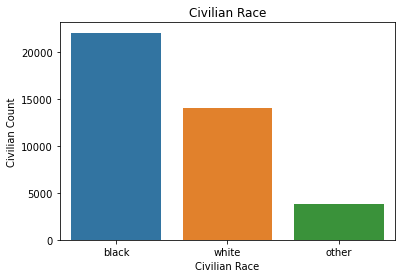

In [65]:
# Using seaborn construct a countplot of civilian race in these encounters
civilian_race = sns.countplot(x=uof_df['race'], 
                    data=uof_df)

civilian_race.set(xlabel="Civilian Race", 
                  ylabel="Civilian Count", 
                  title='Civilian Race');

As can be seen from the graph above, Most use of force incidents occur in the black communities of Indianapolis. These encounters are nearly double that of those who are white in Indianapolis. Other races (hispanic, asian, etc.) are less likely to victims of use of force in Indianapolis.

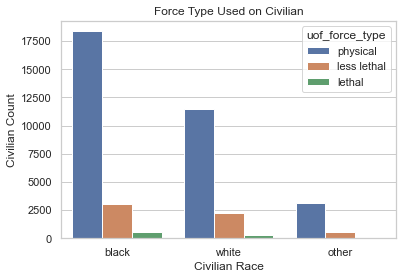

In [66]:
# Create countplot showing race and type of use of force that race experiences

sns.set(style="whitegrid")

race_use_of_force = sns.countplot(x=uof_df['race'], 
                    hue=uof_df['uof_force_type'], 
                    data=uof_df)

race_use_of_force.set(xlabel="Civilian Race", 
                      ylabel="Civilian Count", 
                      title='Force Type Used on Civilian');

As can be seen above, black citizens in Indianapolis alomst face double the amount of use of force compared to their white peers. Most of these encounters result in an officer using some sort of physical force on a black person.

#### Uniformed Officer Race Data

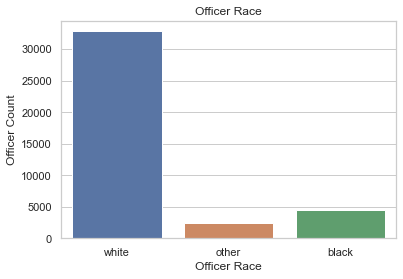

In [67]:
# Create countplot of Officer Race
off_race = sns.countplot(x=uof_df['off_race'], 
                    data=uof_df)

off_race.set(xlabel="Officer Race", 
                  ylabel="Officer Count", 
                  title='Officer Race');

The countplot shows that most officers in Indianapolis are white. The amount of officers of color to white police officers is thousands less than their white counterparts. But, does this have an effect on uof? Let's see the graph bellow.

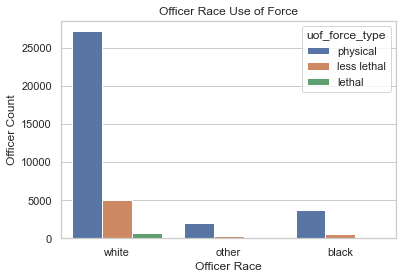

In [68]:
# Create use of force countplot showing officer race and type of use of force used
off_race_use_of_force = sns.countplot(x='off_race', 
                    hue='uof_force_type', 
                    data=uof_df)

off_race_use_of_force.set(xlabel="Officer Race", 
                          ylabel="Officer Count", 
                          title='Officer Race Use of Force');

This is actually an alarming chart. This chart shows that white officers are for more likely to use physical force than officers of colors, but they are also more liley to use less lethal force (such as a taser) or lethal force than officers of color. It's a very interesting picture that begins to paint these encounters not just as officers doing their duty, but that there is some sort of racial disconnect between the officers and those in the community that they are supposed to be serving. 

#### Injury and Use of Force

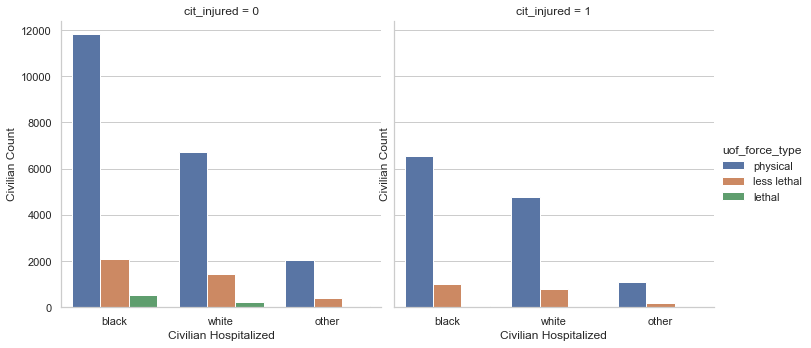

In [69]:
# Create a catplot showing what type of force injured civillians 
race_hosp_use_of_force = sns.catplot(x='race', 
                    hue='uof_force_type',
                    col='cit_injured',
                    kind='count',
                    data=uof_df)

race_hosp_use_of_force.set(xlabel="Civilian Hospitalized", 
                           ylabel="Civilian Count");

As can be seen above, black civillian's are far more likely to be injured than white and other races in Indianapolis. However we see that black civilians are far more likely to be injured by lethal force than white civilians - It's actualy nearly double. I also see that thousands of black civilians have been injured by physical force alone - which is also almost nearly double that of white civilians.

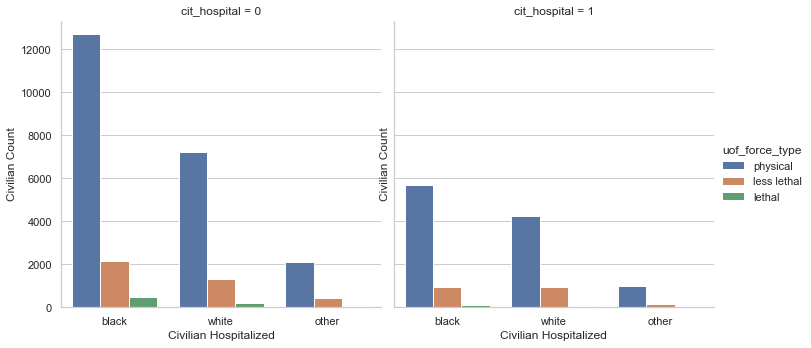

In [70]:
# Catplot showing use of force that led to hospilization
race_hosp_use_of_force = sns.catplot(x='race', 
                    hue='uof_force_type',
                    col='cit_hospital',
                    kind='count',
                    data=uof_df)

race_hosp_use_of_force.set(xlabel="Civilian Hospitalized", 
                           ylabel="Civilian Count");

To build further on the notion of injury, I can see that black civilians are far more likely to be hospolized for their injures. Majority of the time these injuries are due to physical force. 

### Sex and Use of Force

* Does sex play a role in what type of use of force will be used during a use of force encounter?

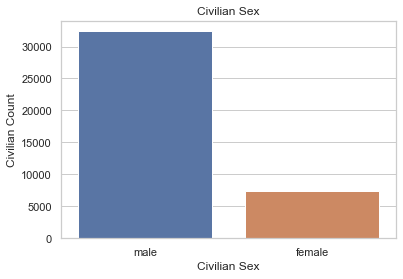

In [71]:
# Countplot of sexes that mostly face use of force incidents
civilian_race = sns.countplot(x=uof_df['sex'], 
                    data=uof_df)

civilian_race.set(xlabel="Civilian Sex", 
                  ylabel="Civilian Count", 
                  title='Civilian Sex');

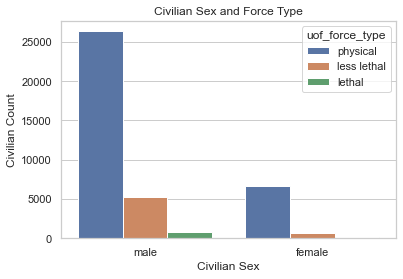

In [72]:
# Countplot of type of use of force each sex experience
race_use_of_force = sns.countplot(x=uof_df['sex'], 
                    hue=uof_df['uof_force_type'], 
                    data=uof_df)

race_use_of_force.set(xlabel="Civilian Sex", 
                      ylabel="Civilian Count", 
                      title='Civilian Sex and Force Type');

The graphs above are very interesting. I can see that males are much more likely to experience use off orce than females. I can also see that officers are much more lkely to use lethal force against a male than a female.

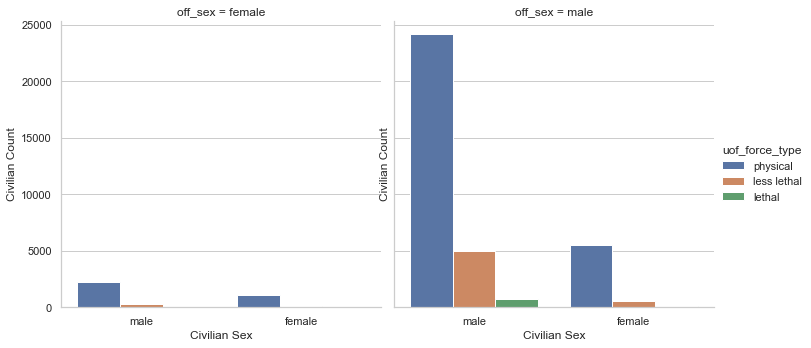

In [73]:
off_sex_use_of_force = sns.catplot(x='sex', 
                    hue='uof_force_type',
                    col='off_sex',
                    kind='count',
                    data=uof_df)

off_sex_use_of_force.set(xlabel="Civilian Sex", 
                           ylabel="Civilian Count");

The catplot shows us even more that female cops are less likely than male cops to use use of force on a civilian. However, both male and female cops are still more likely to use force on male civilians.

### Folium Map of UOF

Folium is a great tool that allows the user to create maps in order to represent aspects of the data. In my case, I will be using Latitude and Longitude in order to represent where use of force occurs in Indianapolis. I'm looking to see if locations determines the type of force that an individual may experience.

In [123]:
# import the cleaned data set 
cleaned_uof_df = pd.read_csv('cleaned_uof_data.csv')
# Drop excess NaN values that were never removed
cleaned_uof_df = cleaned_uof_df.dropna()

In [146]:
# Replace force types with colors for mapping purposes
target = cleaned_uof_df['uof_force_type'].replace('physical', 'green').replace('less lethal', 'yellow').replace('lethal', 'red')

# Create df containing latitude and longitude coordinates
# Drop duplicate lat and long
geo_df = cleaned_uof_df[['lat', 'long']]
geo_df = df.drop_duplicates(subset=['lat', 'long'])

# Concat target and geo_df. Drop NaN values.
geo_df = pd.concat([target, geo_df], axis=1)
geo_df = geo_df.dropna()

# Determine folium map starting location
geo_m = folium.Map(
    location=[39.791000, -86.148003],
    tiles='cartodbpositron',
    zoom_start=10,
)


# Create circle points on map using colors from status_group and then apply to lat_long_m
for i, j in geo_df.iterrows():
    folium.Circle([j['lat'], j['long']],
                 radius=10,
                 fill=True,
                 color=j['uof_force_type'],
                 fill_opacity=0.2
                 ).add_to(geo_m)
    
# Save map as html file
geo_m.save('latlong_uof_map.html')

geo_m

Looking at this map, it seems that there is no rhyme or reason as to why certain types of use of force are occuring in these areas. I do notice that there are more clusters in the central of the city, so it is possible that as one ventures into the heart of Indianapolis they could face more incidents of use off force. But, let's try this map again using race instead of use of force

In [147]:
cleaned_uof_df['race'].value_counts()

black    21269
white    13729
other     3694
Name: race, dtype: int64

In [152]:
# Replace race types with colors for mapping purposes
race_markers = cleaned_uof_df['race'].replace('black', 'green').replace('white', 'yellow').replace('other', 'red')

# Concat target and geo_df. Drop NaN values.
race_geo_df = pd.concat([race_markers, geo_df[['lat', 'long']]], axis=1)
race_geo_df = race_geo_df.dropna()

# Determine folium map starting location
race_geo_m = folium.Map(
    location=[39.791000, -86.148003],
    tiles='cartodbpositron',
    zoom_start=10,
)

# Create circle points on map using colors from status_group and then apply to lat_long_m
for i, j in race_geo_df.iterrows():
    folium.Circle([j['lat'], j['long']],
                 radius=10,
                 fill=True,
                 color=j['race'],
                 fill_opacity=0.2
                 ).add_to(race_geo_m)
    
# Save map as html file
race_geo_m.save('latlong_race_map.html')

race_geo_m

Well, that didn't explain much either. It seems that location might not determine what type of force one may face in Indianapolis. Every incident does look centralized, but I can't clearly determine which race is experiencing more incidents with the police.

### Use of Force by Month and Day

This question may come out of left field, but has month or day played an important role in what type of use of force and individual will experience? Let's take a look and see

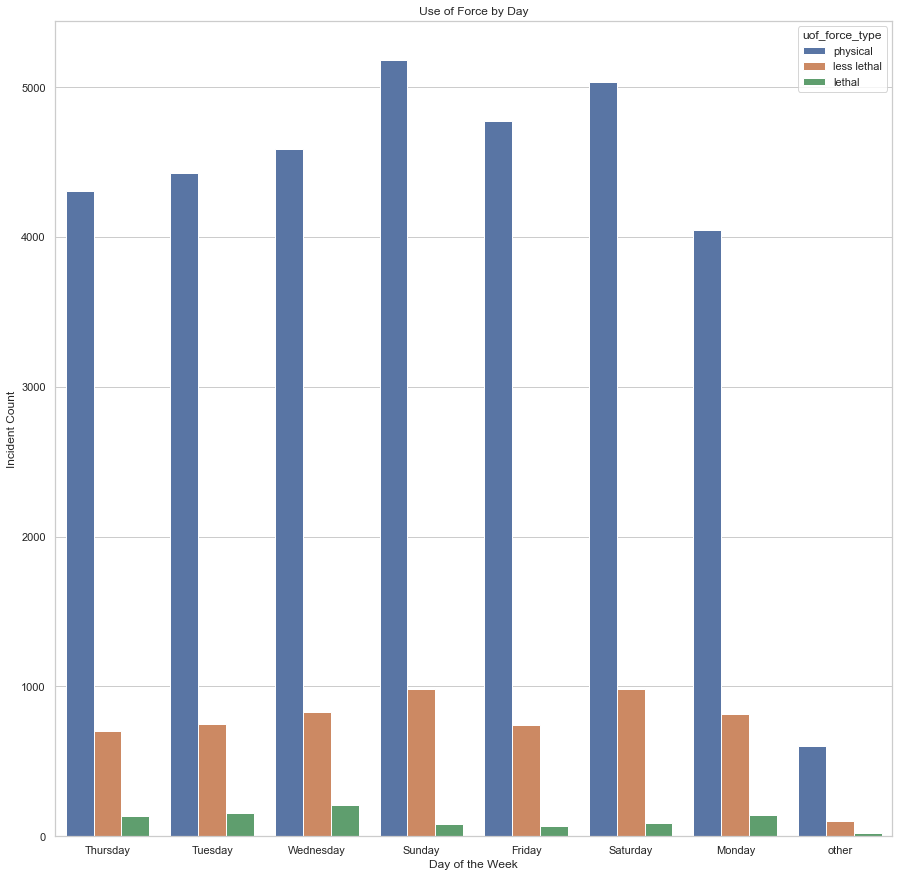

In [153]:
# Create Use of Force by Day graph

fig_dims = (15, 15)
fig, ax = plt.subplots(figsize=fig_dims)

race_use_of_force = sns.countplot(x=uof_df['occurred_wd'], 
                    hue=uof_df['uof_force_type'], 
                    data=uof_df, ax=ax)

race_use_of_force.set(xlabel="Day of the Week", 
                      ylabel="Incident Count", 
                      title='Use of Force by Day');

So, does the day actually matter? No, not really. However, one is slightly more likely to experience physical or less lethal use of force on the weekend in Indianapolis but more likely to experience lethal force from Monday to Thursday. Is this coincidence or hard fact? That's very hard to determine. However, it is interesting that over the years that this info has been collected that it has situated itself in this manner. I would expect more encounters with police to happen on weekends when people are normally off from work and out and about in the city. But then, why would more lethal force methods happen during the week? This graph does raise a lot of questions, but the answers to those questions are outside the purview of this dataset.

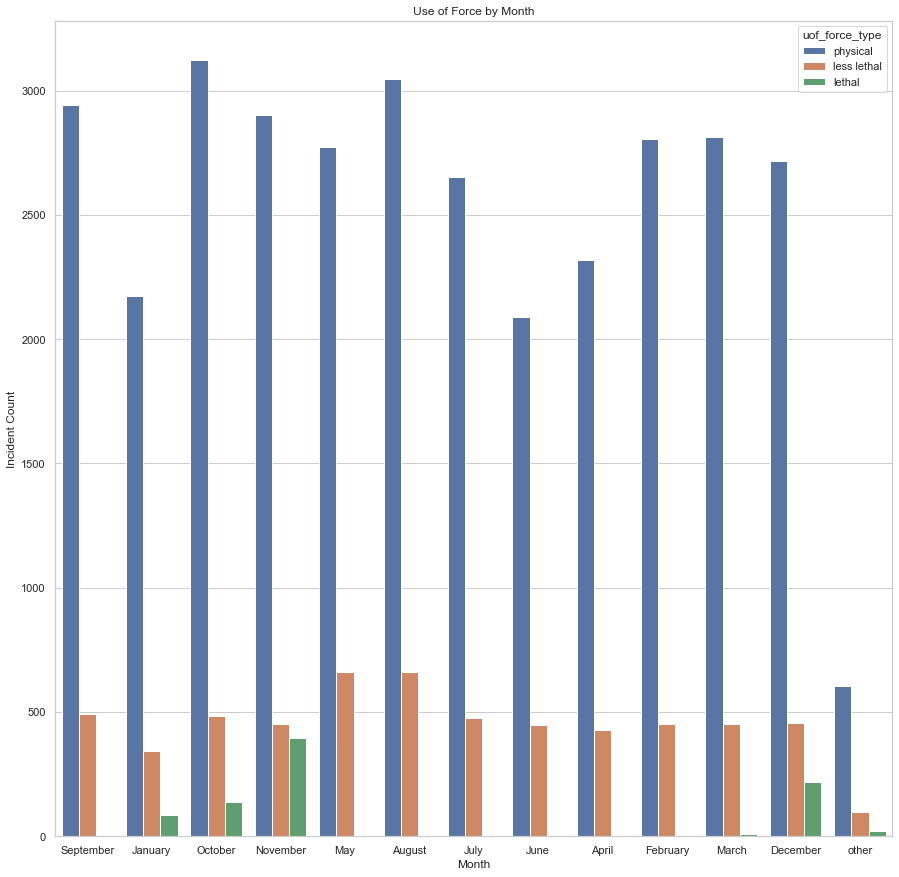

In [154]:
fig_dims = (15, 15)
fig, ax = plt.subplots(figsize=fig_dims)


race_use_of_force = sns.countplot(x=uof_df['occurred_month'], 
                    hue=uof_df['uof_force_type'], 
                    data=uof_df, ax=ax)

race_use_of_force.set(xlabel="Month", 
                      ylabel="Incident Count", 
                      title='Use of Force by Month');

The days definitely raised questions, but the months raise even more. The thing that stands out to me here is that lethal use of force drastically raises during the winter months. From October to january we see a clear bell curve pertaining to these incidents, with most of these incidents occuring in November. I can see that you are also more likley to face less lethal force during the summer months, especially May and August. Again, these charts bring up more questions that, at this point and time, I don't have an answer for (if an answer even exists).

## Models

Now that the data has been cleaned and some aspects of it have been explored, it's time to create my models. In this case I will use use of force as my target variable and determine if the variables used in the model can help in determining correctly the use of force that the civilian faced and the officer used. Since this is a multi-class classification problem, I focused on using K-Nearest Neighbors, Naive bayes, Decision Trees, Random Forest, and XGBoost since these models handle classification models that are non-binary much more efficently.

###  Model Prep

I'm going to prepare the model by making sure the cleaned_uof_df doesn't have any datatype issues or NaN values. I know I'm re-importing it here, but I want to show the process.

In [161]:
# Import cleaned CSV
cleaned_uof_df = pd.read_csv('cleaned_uof_data.csv')

In [162]:
# Drop remaining NaN values 
cleaned_uof_df = cleaned_uof_df.dropna()
cleaned_uof_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38692 entries, 0 to 38691
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   disposition     38692 non-null  object 
 1   uof_force_type  38692 non-null  object 
 2   uof_reason      38692 non-null  object 
 3   service_type    38692 non-null  object 
 4   cit_arrested    38692 non-null  float64
 5   citcharge_type  38692 non-null  object 
 6   cit_injured     38692 non-null  float64
 7   cit_hospital    38692 non-null  float64
 8   off_injured     38692 non-null  float64
 9   off_hospital    38692 non-null  float64
 10  race            38692 non-null  object 
 11  sex             38692 non-null  object 
 12  cit_age         38692 non-null  float64
 13  cit_cond_type   38692 non-null  object 
 14  off_race        38692 non-null  object 
 15  off_sex         38692 non-null  object 
 16  off_age         38692 non-null  float64
 17  off_yr_employ   38692 non-null 

In [163]:
# Ensure that everything is the right data type
cleaned_uof_df['cit_arrested'] = cleaned_uof_df['cit_arrested'].astype(np.int64)
cleaned_uof_df['cit_injured'] = cleaned_uof_df['cit_injured'].astype(np.int64)
cleaned_uof_df['cit_hospital'] = cleaned_uof_df['cit_hospital'].astype(np.int64)
cleaned_uof_df['off_injured'] = cleaned_uof_df['off_injured'].astype(np.int64)
cleaned_uof_df['cit_age'] = cleaned_uof_df['cit_age'].astype(np.int64)
cleaned_uof_df['off_age'] = cleaned_uof_df['off_age'].astype(np.int64)
cleaned_uof_df['off_yr_employ'] = cleaned_uof_df['off_yr_employ'].astype(np.int64)

In [164]:
# Create dummy variabes
dummy_feat = pd.get_dummies(cleaned_uof_df[['disposition', 'uof_reason', 'service_type', 'citcharge_type', 'race', 'sex', 'cit_cond_type', 'off_race', 'off_sex', 'off_cond_type', 'uo_designation', 'occurred_wd', 'occurred_month']], drop_first=True)

In [165]:
# Look for multicoliniarity among continuous values

# Label encode target variable
le = LabelEncoder()
le_target = le.fit_transform(cleaned_uof_df['uof_force_type'])
le_target = pd.DataFrame(data=le_target)
le_target = le_target.rename(columns={0: 'uof_type'})

# Create continuos variables df
cont_var = cleaned_uof_df[['cit_arrested', 'cit_injured', 'cit_hospital', 'off_injured', 'off_hospital', 'cit_age', 'off_age', 'off_yr_employ', 'lat', 'long']]

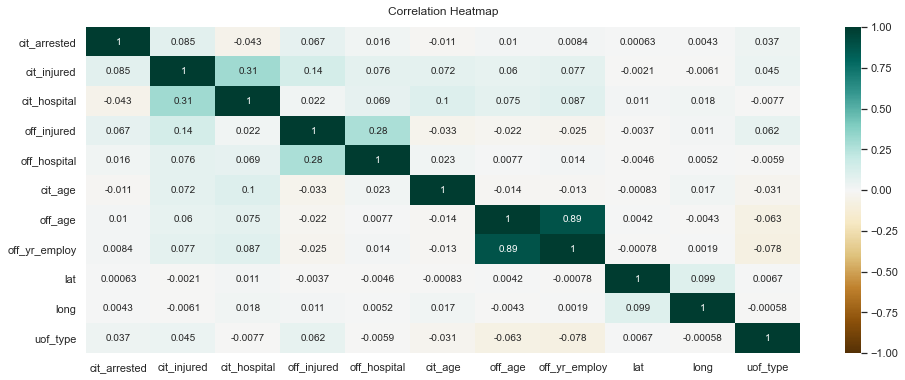

In [166]:
plt.figure(figsize=(16, 6))
corr_matrix = pd.concat([cont_var, le_target], axis=1)
heatmap = sns.heatmap(corr_matrix.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

I can see that off_yr_employ and off_age are high correlated. I'm going to drop age and keep years employed

In [167]:
cleaned_uof_df = cleaned_uof_df.drop(['off_age'], axis=1)

In [168]:
finalized_uof_df = pd.concat([cleaned_uof_df[['cit_arrested', 'cit_injured', 'cit_hospital', 'off_injured', 'off_hospital', 'cit_age', 'off_yr_employ', 'lat', 'long']], dummy_feat], axis=1)

### K-Nearest Neighbors

K-Nearest Neighbor is a supervised learning model in which the number of n_neighbors used determines the accuracy of the model. k-NN is a distance based classifier, and uses the distance between the points in order to classify the unknown values in the model. k-nearest neighbor can work great for smaller datasets, but as the dimensionality increases it becomes less effective. In order to oush back against the curs of dimentionality, I will be using PCA to see if I can create a more accurate model.

In [170]:
# Create knn X and y values
knn_y = cleaned_uof_df[['uof_force_type']]
knn_X = finalized_uof_df

In [171]:
# Set up training and testing sets
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(knn_X, knn_y, test_size=None, random_state=42)

In [172]:
# Create k-NN Classifier instance
base_knn_clf = KNeighborsClassifier()

# Fit training sets to classifier and then run prediction on X testing values
base_knn_clf.fit(knn_X_train, knn_y_train)
base_knn_predicted = base_knn_clf.predict(knn_X_test)

# Calculate f1 and accuracy scores
base_knn_f1 = f1_score(base_knn_predicted, knn_y_test, average='weighted')
base_knn_acc = accuracy_score(base_knn_predicted, knn_y_test)

print('f1 Score:', '{:04.2f}'.format(base_knn_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(base_knn_acc*100)+'%')

print('\n')
print(classification_report(knn_y_test, base_knn_predicted, target_names=['less lethal', 'lethal', 'physical']))


f1 Score: 88.33%
accuracy Score: 87.29%


              precision    recall  f1-score   support

 less lethal       0.67      0.45      0.54      1467
      lethal       0.73      0.60      0.66       185
    physical       0.90      0.96      0.93      8021

    accuracy                           0.87      9673
   macro avg       0.77      0.67      0.71      9673
weighted avg       0.86      0.87      0.86      9673



The base model came out really well. Since this is an imbalanced categorical problem it is better to go with the f1 score for accuracy over the accuracy score because it takes into account the harmonic mean. Overall this is a really nice base model, but let's see if I can improve upon it using RandomizedSearchCV to tune my hyperparameters.  

In [173]:
# setup parameters to be tested 
n_neighbors = [3,5,11,19]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan']
algorithm = ['ball_tree', 'kd_tree', 'brute']
leaf_size = [10,20,30,40,50]

knn_random_params = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric,
    'algorithm': algorithm
}

knn_rs = RandomizedSearchCV(
     KNeighborsClassifier(),
     knn_random_params,
     verbose = 2,
     cv = 3,
     n_jobs = -1)

# Fit training sets
knn_rs_results = knn_rs.fit(knn_X_train, knn_y_train)

# Print best hyperparameters
knn_rs_results.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.9min finished


KNeighborsClassifier(algorithm='kd_tree', metric='manhattan', n_neighbors=3,
                     weights='distance')

In [176]:
# Create k-NN Classifier instance
ht_knn_clf = KNeighborsClassifier(algorithm='kd_tree', 
                                    metric='manhattan', 
                                    n_neighbors=3,
                                    weights='distance')

# Fit training sets to classifier and then run prediction on X testing values
ht_knn_clf.fit(knn_X_train, knn_y_train)
ht_knn_predicted = ht_knn_clf.predict(knn_X_test)

ht_knn_f1 = f1_score(ht_knn_predicted, knn_y_test, average='weighted')
ht_knn_acc = accuracy_score(ht_knn_predicted, knn_y_test)

print('f1 Score:', '{:04.2f}'.format(ht_knn_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(ht_knn_acc*100)+'%')

print('\n')
print(classification_report(knn_y_test, ht_knn_predicted, target_names=['less lethal', 'lethal', 'physical']))

f1 Score: 92.91%
accuracy Score: 92.84%


              precision    recall  f1-score   support

 less lethal       0.80      0.76      0.78      1467
      lethal       0.85      0.77      0.81       185
    physical       0.95      0.96      0.96      8021

    accuracy                           0.93      9673
   macro avg       0.87      0.83      0.85      9673
weighted avg       0.93      0.93      0.93      9673



Wow, with a little tweaking the model has improved greatly. With an f1 score of 92.91 and precision and recall scores that classify majority of the categories very well. This is a very strong model and it shows that our variables have an impact on our target variable. But, is it possible to make this model even stronger? Let's try some PCA.

In [177]:
# Split continuous and categorical variables in order to run PCA on continuous features
knn_cont_feat = cleaned_uof_df[['cit_arrested',
                                'cit_injured',
                                'cit_hospital',
                                'off_injured',
                                'off_hospital',
                                'cit_age',
                                'off_yr_employ',
                                'lat',
                                'long'
                               ]]

knn_cat_feat = cleaned_uof_df[['disposition',
                                'uof_reason',
                                'service_type',
                                'citcharge_type',
                                'race',
                                'sex',
                                'cit_cond_type',
                                'off_race',
                                'off_sex',
                                'off_cond_type',
                               'uo_designation',
                               'occurred_wd',
                               'occurred_month'
                               ]]

# Get dummies for categorical variables
knn_feat_dummies = pd.get_dummies(knn_cat_feat, drop_first=True)

In [178]:
# Use MinMaxScaler to scale features
scaler_minmax = MinMaxScaler()
minmax_knn_cont_feat = scaler_minmax.fit_transform(knn_cont_feat)

# Use PCA to reduce dimensionality
pca = PCA()
pca_knn_cont = pca.fit_transform(minmax_knn_cont_feat)
pca_knn_cont_df = pd.DataFrame(pca_knn_cont, columns = knn_cont_feat.columns)

knn_pca_df = pd.concat([pca_knn_cont_df, knn_feat_dummies], axis=1)

In [179]:
# Create new pca X and y
pca_knn_y = cleaned_uof_df[['uof_force_type']]
pca_knn_X = knn_pca_df

In [180]:
# Create training and testing sets
pca_knn_X_train, pca_knn_X_test, pca_knn_y_train, pca_knn_y_test = train_test_split(pca_knn_X, pca_knn_y, test_size=None, random_state=42)

In [181]:
# Create k-NN Classifier instance
base_pca_knn_clf = KNeighborsClassifier()

# Fit training sets to classifier and then run prediction on X testing values
base_pca_knn_clf.fit(pca_knn_X_train, pca_knn_y_train)
base_pca_knn_predicted = base_pca_knn_clf.predict(pca_knn_X_test)

base_pca_knn_f1 = f1_score(base_pca_knn_predicted, pca_knn_y_test, average='weighted')
base_pca_knn_acc = accuracy_score(base_pca_knn_predicted, pca_knn_y_test)

print('f1 Score:', '{:04.2f}'.format(base_pca_knn_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(base_pca_knn_acc*100)+'%')

print('\n')
print(classification_report(pca_knn_y_test, base_pca_knn_predicted, target_names=['less lethal', 'lethal', 'physical']))


f1 Score: 88.47%
accuracy Score: 87.52%


              precision    recall  f1-score   support

 less lethal       0.67      0.46      0.54      1467
      lethal       0.80      0.66      0.72       185
    physical       0.90      0.96      0.93      8021

    accuracy                           0.88      9673
   macro avg       0.79      0.69      0.73      9673
weighted avg       0.86      0.88      0.87      9673



Playing with the dimensionality of the model using PCA did produce a slightly better base model than the initila base model when it came to both the f1 and accuracy scores. I will see if tuning this mode will produce better results.

In [182]:
# fit to tune hyperparameters 
pca_knn_rs_results = knn_rs.fit(pca_knn_X_train, pca_knn_y_train)

# Print best hyperparameters
pca_knn_rs_results.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.3min finished


KNeighborsClassifier(algorithm='brute', metric='manhattan', weights='distance')

In [213]:
# Create k-NN Classifier instance
ht_pca_knn_clf = KNeighborsClassifier(algorithm='brute', 
                                      metric='manhattan', 
                                      weights='distance')

# Fit training sets to classifier and then run prediction on X testing values
ht_pca_knn_clf.fit(pca_knn_X_train, pca_knn_y_train)
ht_pca_knn_predicted = ht_pca_knn_clf.predict(pca_knn_X_test)

ht_pca_knn_f1 = f1_score(ht_pca_knn_predicted, pca_knn_y_test, average='weighted')
ht_pca_knn_acc = accuracy_score(ht_pca_knn_predicted, pca_knn_y_test)

print('f1 Score:', '{:04.2f}'.format(ht_pca_knn_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(ht_pca_knn_acc*100)+'%')

print('\n')
print(classification_report(pca_knn_y_test, ht_pca_knn_predicted, target_names=['less lethal', 'lethal', 'physical']))

f1 Score: 89.79%
accuracy Score: 89.51%


              precision    recall  f1-score   support

 less lethal       0.70      0.61      0.65      1467
      lethal       0.86      0.72      0.78       185
    physical       0.93      0.95      0.94      8021

    accuracy                           0.90      9673
   macro avg       0.83      0.76      0.79      9673
weighted avg       0.89      0.90      0.89      9673



The PCA model did perform better than both the Base models, but perfomed worse than the tuned non-PCA model.

### Naive Bayes

Naive Bayes is a type of supervised classification learning model. A Naive Bayes model makes the assumption that each feature is independent from one another. Let's try a base model and see how this model performs

In [183]:
nb_y = cleaned_uof_df[['uof_force_type']]
nb_X = finalized_uof_df

In [184]:
nb_X_train, nb_X_test, nb_y_train, nb_y_test = train_test_split(nb_X, nb_y, test_size=None, random_state=42)

In [216]:
# Create k-NN Classifier instance
base_nb_clf = GaussianNB()

# Fit training sets to classifier and then run prediction on X testing values
base_nb_clf.fit(nb_X_train, nb_y_train)
base_nb_predicted = base_nb_clf.predict(nb_X_test)

base_nb_f1 = f1_score(base_nb_predicted, nb_y_test, average='weighted')
base_nb_acc = accuracy_score(base_nb_predicted, nb_y_test)

print('f1 Score:', '{:04.2f}'.format(base_nb_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(base_nb_acc*100)+'%')

print('\n')
print(classification_report(nb_y_test, base_nb_predicted, target_names=['less lethal', 'lethal', 'physical']))

f1 Score: 17.07%
accuracy Score: 17.85%


              precision    recall  f1-score   support

 less lethal       0.19      0.54      0.28      1467
      lethal       0.04      0.98      0.07       185
    physical       0.98      0.09      0.17      8021

    accuracy                           0.18      9673
   macro avg       0.40      0.54      0.17      9673
weighted avg       0.84      0.18      0.19      9673



This model did not perform well at all. With an f1 score of 17 and terrible precision and recall scores, this model would be considered unacceptable. Naive Bayes does work better for binary classifications, so maybe this is why it did not perform well. But, tuning this model won't even make it perform better, so I am going to move onto models that I believe are far stroger for multi-classification problems.

### Decision Trees

Decision trees are a non-parametric supervised learning model. It predicts the values of a target variable by inferring from the features of the dataset and using these inferences to learn simple decision rules. Since this problem is a multi-class clasification problem, I will be using the DecisionTreeClassifier. 

In [186]:
# Create X and y values
dt_y = cleaned_uof_df[['uof_force_type']]
dt_X = finalized_uof_df

In [187]:
# Split data into testing and training sets
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(dt_X, dt_y, test_size=None, random_state=42)

In [188]:
# Run base DT classifier
base_dt = DecisionTreeClassifier(random_state=42)
base_dt.fit(dt_X_train, dt_y_train)
base_dt_predicted = base_dt.predict(dt_X_test)

# Calculate f1 and acuracy score
base_dt_f1 = f1_score(base_dt_predicted, dt_y_test, average='weighted')
base_dt_acc = accuracy_score(base_dt_predicted, dt_y_test)

print('f1 Score:', '{:04.2f}'.format(base_dt_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(base_dt_acc*100)+'%')

print('\n')
print(classification_report(dt_y_test, base_dt_predicted, target_names=['less lethal', 'lethal', 'physical']))

f1 Score: 90.23%
accuracy Score: 90.22%


              precision    recall  f1-score   support

 less lethal       0.70      0.70      0.70      1467
      lethal       0.78      0.79      0.78       185
    physical       0.94      0.94      0.94      8021

    accuracy                           0.90      9673
   macro avg       0.81      0.81      0.81      9673
weighted avg       0.90      0.90      0.90      9673



My base decision tree model managed to score an f1 score of 90.23, which is incredible. Looking at the precision and recall scores of this model I can also see that they produced scores that were also very good. I do see, however, that physical does weigh more in the decision process. Let's see if I can improve upon this model by fine tunning my parameters.

In [189]:
# Prepare param_grib for Randomized Search CV

criterion = ['gini', 'entropy']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
splitter = ['best', 'random']
max_features = ['auto', 'sqrt']
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 3, 4, 5, 6]

In [190]:
# Run Randomized Search CV and determine best estimators for decision tree model
dt_clf = RandomForestClassifier()

dt_random_grid = { 'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'n_estimators': n_estimators
        }

dt_rs = RandomizedSearchCV(estimator = dt_clf, 
                           param_distributions = dt_random_grid, 
                           n_iter = 100,
                           cv = 3, 
                           verbose=2, 
                           random_state=11, 
                           n_jobs = -1)


# Fit to cv
dt_rs_results = dt_rs.fit(dt_X_train, dt_y_train)

# Print best estimators
dt_rs_results.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 39.7min finished


RandomForestClassifier(criterion='entropy', max_depth=60, max_features='sqrt',
                       n_estimators=800)

In [191]:
ht_dt = DecisionTreeClassifier(random_state=42, 
                                 criterion='entropy', 
                                 max_depth=60,
                                 max_features='sqrt',
                                 n_estimators=800)

ht_dt.fit(dt_X_train, dt_y_train)
ht_dt_predicted = ht_dt.predict(dt_X_test)

ht_dt_f1 = f1_score(ht_dt_predicted, dt_y_test, average='weighted')
ht_dt_acc = accuracy_score(ht_dt_predicted, dt_y_test)

print('f1 Score:', '{:04.2f}'.format(ht_dt_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(ht_dt_acc*100)+'%')

print('\n')
print(classification_report(dt_y_test, ht_dt_predicted, target_names=['less lethal', 'lethal', 'physical']))

f1 Score: 89.99%
accuracy Score: 90.03%


              precision    recall  f1-score   support

 less lethal       0.69      0.70      0.70      1467
      lethal       0.80      0.81      0.80       185
    physical       0.94      0.94      0.94      8021

    accuracy                           0.90      9673
   macro avg       0.81      0.82      0.81      9673
weighted avg       0.90      0.90      0.90      9673



I will now try to use SmoteNC in order to see if it can fix the imbalances. Let's see if the decision tree models performs better.

In [192]:
# fir training sets to SMOTENC
smtnc = SMOTENC([0], random_state=42, sampling_strategy='minority')
smtnc_dt_X_train, smtnc_dt_y_train = smtnc.fit_resample(dt_X_train, dt_y_train)

In [193]:
# Fit to classifier and then run prediction
base_smtnc_dt = DecisionTreeClassifier(random_state=42)
base_smtnc_dt.fit(smtnc_dt_X_train, smtnc_dt_y_train)
base_smtnc_dt_predicted = base_smtnc_dt.predict(dt_X_test)

# Calculate f1 and accuracy scores
base_smtnc_dt_f1 = f1_score(base_smtnc_dt_predicted, dt_y_test, average='weighted')
base_smtnc_dt_acc = accuracy_score(base_smtnc_dt_predicted, dt_y_test)

print('f1 Score:', '{:04.2f}'.format(base_smtnc_dt_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(base_smtnc_dt_acc*100)+'%')

print('\n')
print(classification_report(dt_y_test, base_smtnc_dt_predicted, target_names=['less lethal', 'lethal', 'physical']))

f1 Score: 89.72%
accuracy Score: 89.77%


              precision    recall  f1-score   support

 less lethal       0.69      0.70      0.69      1467
      lethal       0.68      0.76      0.71       185
    physical       0.94      0.94      0.94      8021

    accuracy                           0.90      9673
   macro avg       0.77      0.80      0.78      9673
weighted avg       0.90      0.90      0.90      9673



The SMOTE model sadly did not outperform the non SMOTE models, sadly. However, it did not erform poorly with an f1 score of 89.72. Let's see if fine tuning this model creates better results.

In [194]:
# Run Randomized Search CV and determine best estimators for random forest model
dt_clf = RandomForestClassifier()

dt_random_grid = { 'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'n_estimators': n_estimators
        }

dt_rs = RandomizedSearchCV(estimator = dt_clf, 
                           param_distributions = dt_random_grid, 
                           n_iter = 100,
                           cv = 3, 
                           verbose=2, 
                           random_state=11, 
                           n_jobs = -1)


# Fit training sets 
smtnc_dt_rs_results = dt_rs.fit(smtnc_dt_X_train, smtnc_dt_y_train)

# Print best estimators
smtnc_dt_rs_results.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 65.5min finished


RandomForestClassifier(criterion='entropy', max_depth=60, max_features='sqrt',
                       n_estimators=800)

In [217]:
ht_smtnc_dt = DecisionTreeClassifier(random_state=42, 
                                     criterion='entropy', 
                                     max_depth=60, 
                                     max_features='sqrt')

ht_smtnc_dt.fit(smtnc_dt_X_train, smtnc_dt_y_train)
ht_smtnc_dt_predicted = base_smtnc_dt.predict(dt_X_test)

ht_smtnc_dt_f1 = f1_score(ht_smtnc_dt_predicted, dt_y_test, average='weighted')
ht_smtnc_dt_acc = accuracy_score(ht_smtnc_dt_predicted, dt_y_test)

print('f1 Score:', '{:04.2f}'.format(ht_smtnc_dt_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(ht_smtnc_dt_acc*100)+'%')

print('\n')
print(classification_report(dt_y_test, ht_smtnc_dt_predicted, target_names=['less lethal', 'lethal', 'physical']))

f1 Score: 89.72%
accuracy Score: 89.77%


              precision    recall  f1-score   support

 less lethal       0.69      0.70      0.69      1467
      lethal       0.68      0.76      0.71       185
    physical       0.94      0.94      0.94      8021

    accuracy                           0.90      9673
   macro avg       0.77      0.80      0.78      9673
weighted avg       0.90      0.90      0.90      9673



Weirdly enough, there was no change in the models scoring.The base and tuned model performed exactly the same and were not better than the tuned decision tree model that did not use SMOTE

### Random Forest

Random Forest is a supervised learning algorithm method that uses an ensemble of multiple decision learning trees in order to determine the best classifier for the model. Random Forest is considered a powerful learning algorithm because it works by searching for the best features among a random subset of features. Let's run a base model first ans see how this model performs.

In [196]:
# Create X and y values
rf_y = cleaned_uof_df[['uof_force_type']]
rf_X = finalized_uof_df

In [197]:
# Split into training and testing sets
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X, rf_y, test_size=None, random_state=42)

In [199]:
# Fit x and y training set to clasifier and predict using x test
base_rf = RandomForestClassifier(random_state=42)
base_rf.fit(rf_X_train, rf_y_train)
base_rf_predicted = base_rf.predict(rf_X_test)

# Calculate f1 and accuracy scores
base_rf_f1 = f1_score(base_rf_predicted, rf_y_test, average='weighted')
base_rf_acc = accuracy_score(base_rf_predicted, rf_y_test)

print('f1 Score:', '{:04.2f}'.format(base_rf_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(base_rf_acc*100)+'%')

print('\n')
print(classification_report(rf_y_test, base_rf_predicted, target_names=['less lethal', 'lethal', 'physical']))


f1 Score: 92.75%
accuracy Score: 92.06%


              precision    recall  f1-score   support

 less lethal       0.90      0.58      0.71      1467
      lethal       0.86      0.75      0.80       185
    physical       0.92      0.99      0.95      8021

    accuracy                           0.92      9673
   macro avg       0.89      0.77      0.82      9673
weighted avg       0.92      0.92      0.91      9673



My random forest model produced an f1 score of 92.75 and an accuracy score that was almost identical. This is a great score for a base model, however I do notice that the imbalances have created some disparity among the precision and recall scores of the model. But, even though there are some disparities, the f1 score of each classification is above 70%. Let's see if fine tuning my model will produce better results

In [201]:
# Run Randomized Search CV and determine best estimators for random forest model
rf_clf = RandomForestClassifier()

rf_random_grid = { 'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'n_estimators': n_estimators
        }

rf_rs = RandomizedSearchCV(estimator = dt_clf, 
                           param_distributions = dt_random_grid, 
                           n_iter = 100,
                           cv = 3, 
                           verbose=2, 
                           random_state=11, 
                           n_jobs = -1)


# Fit X and y train
rf_rs_results = rf_rs.fit(rf_X_train, rf_y_train)

# Print best estimators
rf_rs_results.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 39.1min finished


RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=300)

In [202]:
# fit x and y train to tuned classifier and predict x test on it
rf = RandomForestClassifier(random_state=42, 
                            criterion='entropy', 
                            max_depth=100, 
                            n_estimators=300)

rf.fit(rf_X_train, rf_y_train)
rf_predicted = rf.predict(rf_X_test)

# Calculate f1 and accuracy score
rf_f1 = f1_score(rf_predicted, rf_y_test, average='weighted')
rf_acc = accuracy_score(rf_predicted, rf_y_test)

print('f1 Score:', '{:04.2f}'.format(rf_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(rf_acc*100)+'%')

print('\n')
print(classification_report(rf_y_test, rf_predicted, target_names=['less lethal', 'lethal', 'physical']))

f1 Score: 92.85%
accuracy Score: 92.15%


              precision    recall  f1-score   support

 less lethal       0.91      0.58      0.71      1467
      lethal       0.90      0.74      0.81       185
    physical       0.92      0.99      0.95      8021

    accuracy                           0.92      9673
   macro avg       0.91      0.77      0.82      9673
weighted avg       0.92      0.92      0.91      9673



Fine tuning the model only produced slightly higher f1 and accuracy scores and didn't have much impact on the precision or recall of the model. It's a slightly stronger model, but it still has issues because it is an imbalanced model. I am going to use smote again in order to see if this can clean-up the imbalancing issues.

In [203]:
# Setup smote and fit x and y training sets to it
smtnc = SMOTENC([0], random_state=42, sampling_strategy='minority')
smtnc_rf_X_train, smtnc_rf_y_train = smtnc.fit_resample(rf_X_train, rf_y_train)

In [204]:
# Run prediction model on dataset
base_smtnc_rf = RandomForestClassifier(random_state=42)
base_smtnc_rf.fit(smtnc_rf_X_train, smtnc_rf_y_train)
base_smtnc_rf_predicted = base_rf.predict(rf_X_test)

#calculate f1 and acuracy score
base_smtnc_rf_f1 = f1_score(base_smtnc_rf_predicted, rf_y_test, average='weighted')
base_smtnc_rf_acc = accuracy_score(base_smtnc_rf_predicted, rf_y_test)

print('f1 Score:', '{:04.2f}'.format(base_smtnc_rf_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(base_smtnc_rf_acc*100)+'%')

print('\n')
print(classification_report(rf_y_test, base_smtnc_rf_predicted, target_names=['less lethal', 'lethal', 'physical']))


f1 Score: 92.75%
accuracy Score: 92.06%


              precision    recall  f1-score   support

 less lethal       0.90      0.58      0.71      1467
      lethal       0.86      0.75      0.80       185
    physical       0.92      0.99      0.95      8021

    accuracy                           0.92      9673
   macro avg       0.89      0.77      0.82      9673
weighted avg       0.92      0.92      0.91      9673



The model performd slightly worse and didn't make a difference when it came to precision or recall score. Let me fine tune the model and see if that makes a difference.

In [206]:
# Run Randomized Search CV and determine best estimators for random forest model
ht_rf_clf = RandomForestClassifier()

ht_rf_random_grid = { 'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'n_estimators': n_estimators
        }

ht_rf_rs = RandomizedSearchCV(estimator = dt_clf, 
                           param_distributions = dt_random_grid, 
                           n_iter = 100,
                           cv = 3, 
                           verbose=2, 
                           random_state=11, 
                           n_jobs = -1)


ht_rf_rs_results = ht_rf_rs.fit(smtnc_rf_X_train, smtnc_rf_y_train)

# Print best estimators
ht_rf_rs_results.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 65.4min finished


RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=300)

In [207]:
ht_smtnc_rf = RandomForestClassifier(random_state=42, 
                                     criterion='entropy', 
                                     max_depth=100, 
                                     n_estimators=300)

ht_smtnc_rf.fit(smtnc_rf_X_train, smtnc_rf_y_train)
ht_smtnc_rf_predicted = ht_smtnc_rf.predict(rf_X_test)

ht_smtnc_rf_f1 = f1_score(ht_smtnc_rf_predicted, rf_y_test, average='weighted')
ht_smtnc_rf_acc = accuracy_score(ht_smtnc_rf_predicted, rf_y_test)

print('f1 Score:', '{:04.2f}'.format(ht_smtnc_rf_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(ht_smtnc_rf_acc*100)+'%')

print('\n')
print(classification_report(rf_y_test, ht_smtnc_rf_predicted, target_names=['less lethal', 'lethal', 'physical']))


f1 Score: 92.19%
accuracy Score: 91.18%


              precision    recall  f1-score   support

 less lethal       0.91      0.51      0.65      1467
      lethal       0.81      0.84      0.82       185
    physical       0.91      0.99      0.95      8021

    accuracy                           0.91      9673
   macro avg       0.88      0.78      0.81      9673
weighted avg       0.91      0.91      0.90      9673



The fine tuned smote random forest model actually perfomed worse. But, overall the random forest models performed quit well and were very strong models

### XGBoost

XGBoost is considered one of he strongest learning models out there. It works by pruning it's decision trees backwards by using the max_depth of the model as its guide. I will run a base model in order to see how this model fares.

In [208]:
# Create X and y values 
xgb_y = cleaned_uof_df[['uof_force_type']]
xgb_X = finalized_uof_df

In [209]:
# Split into training and testing sets
xgb_X_train, xgb_X_test, xgb_y_train, xgb_y_test = train_test_split(xgb_X, xgb_y, test_size=None, random_state=42)

In [210]:
# fit trainig sets to classifier and predict using X testing set

base_xgb_clf = xgb.XGBClassifier()

base_xgb_clf.fit(xgb_X_train, xgb_y_train)
base_xgb_predicted = base_xgb_clf.predict(xgb_X_test)

# Calculate f1 and accuracy scores
base_xgb_f1 = f1_score(base_xgb_predicted, xgb_y_test, average='weighted')
base_xgb_acc = accuracy_score(base_xgb_predicted, xgb_y_test)

print('f1 Score:', '{:04.2f}'.format(base_xgb_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(base_xgb_acc*100)+'%')

print('\n')
print(classification_report(xgb_y_test, base_xgb_predicted, target_names=['less lethal', 'lethal', 'physical']))

[04:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 Score: 90.40%
accuracy Score: 87.68%


              precision    recall  f1-score   support

 less lethal       0.86      0.27      0.41      1467
      lethal       0.84      0.79      0.82       185
    physical       0.88      0.99      0.93      8021

    accuracy                           0.88      9673
   macro avg       0.86      0.68      0.72      9673
weighted avg       0.88      0.88      0.85      9673



The base model performed well, scoring an f1 score of 90 percent. However, the imbalances did hurt the scoring. I can see that the precision and recall scores for less lethal are so drastically polar that it created a very small f1 score for this part of the model. I will finetune the model in order to see if this makes a difference.

In [211]:
# Create XGBoost Classifier instance
xgb_clf = xgb.XGBClassifier()

# Create a grid of parameters. Depth should have the greatest effect when using XGBoost.
xgb_random_grid = { 'min_child_weight': [1, 5, 10],
                   'learning_rate': [0.1, 0.5, 0.9],
                   'subsample': [0.3, 0.5, 0.9],
                   'colsample_bytree': [0.3, 0.5, 0.8],
                   'gamma': [0.5, 1, 1.5, 2, 5],
                   'subsample': [0.6, 0.8, 1.0],
                   'colsample_bytree': [0.6, 0.8, 1.0],
                   'max_depth': [3, 5, 10, 15, 25, 30]
        }

# Use RandomizedSearchCV in order to determine best possible parameters to use for model.
xgb_rs = RandomizedSearchCV(estimator = xgb_clf, 
                           param_distributions = xgb_random_grid, 
                           n_iter = 100,
                           cv = 3, 
                           verbose=2, 
                           random_state=11, 
                           n_jobs = -1)


# Fit training sets and run RandomizedSearchCV in order to determine best estimators for model.
xgb_rs_results = xgb_rs.fit(xgb_X_train, xgb_y_train)

xgb_rs_results.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 59.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 129.3min finished


[07:07:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=25,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [212]:
xgb_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=25,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

xgb_clf.fit(xgb_X_train, xgb_y_train)
xgb_predicted = xgb_clf.predict(xgb_X_test)

xgb_f1 = f1_score(xgb_predicted, xgb_y_test, average='weighted')
xgb_acc = accuracy_score(xgb_predicted, xgb_y_test)

print('f1 Score:', '{:04.2f}'.format(xgb_f1*100)+'%')
print('accuracy Score:', '{:04.2f}'.format(xgb_acc*100)+'%')

print('\n')
print(classification_report(xgb_y_test, xgb_predicted, target_names=['less lethal', 'lethal', 'physical']))

[07:09:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 Score: 93.52%
accuracy Score: 93.08%


              precision    recall  f1-score   support

 less lethal       0.90      0.65      0.75      1467
      lethal       0.89      0.81      0.85       185
    physical       0.94      0.99      0.96      8021

    accuracy                           0.93      9673
   macro avg       0.91      0.82      0.85      9673
weighted avg       0.93      0.93      0.93      9673



With a f1 score of 93.52, the tuned XGBoost outperformed all other models. 93% of the data can be explained by this model. 

## Results

So why even run this model? What was the purpose? Well the purpose of this model was to appropriately determine if certain features collected by local law enforcement or other institutions can acurately predict and classify the type of use of force that an officer would most likely use when engaged with a civilian. My XGBoost model does just that. Let's take a closer look at it and see what it does well and what it can do better.

In [221]:
# Let's look at the value count so I can explain the confusion matrix better
xgb_y_test.value_counts()

uof_force_type
physical          8021
less lethal       1467
lethal             185
dtype: int64

None


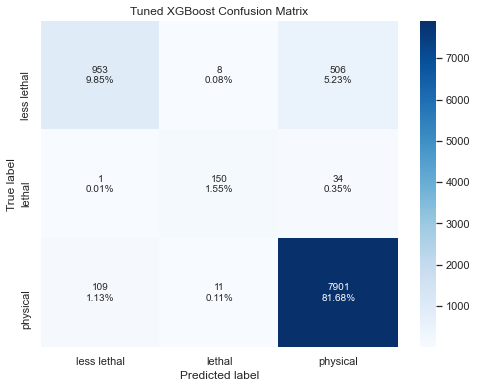

In [218]:
tuned_xgb_matrix = confusion_matrix(xgb_y_test, xgb_predicted)
matrix_labels = ['less lethal', 'lethal', 'physical']
print(make_confusion_matrix(tuned_xgb_matrix, figsize=(8,6), cbar=True, categories=matrix_labels, sum_stats=False, title='Tuned XGBoost Confusion Matrix'))

The confusion matrix above shows some interesting things. 7901 out of 8021 were accurately classified as physical use of force, 150 out 185 were correctly labeled as lethal, and 953 out 1467 were labeled as less lethal. These are really great values. My model is able to correctly label majority of use of force incidents.

However, I do find it interesting that 506 out of 1467 less lethal incidents were mislabled as physical lethal. I wonder what factors from the model assumed this was the case. The same goes for the 109 use of for incidents that were mislabeled as less lethal instead of being labeled as physical force encounters.

Text(0.5, 0, 'XGboost Feature Importance')

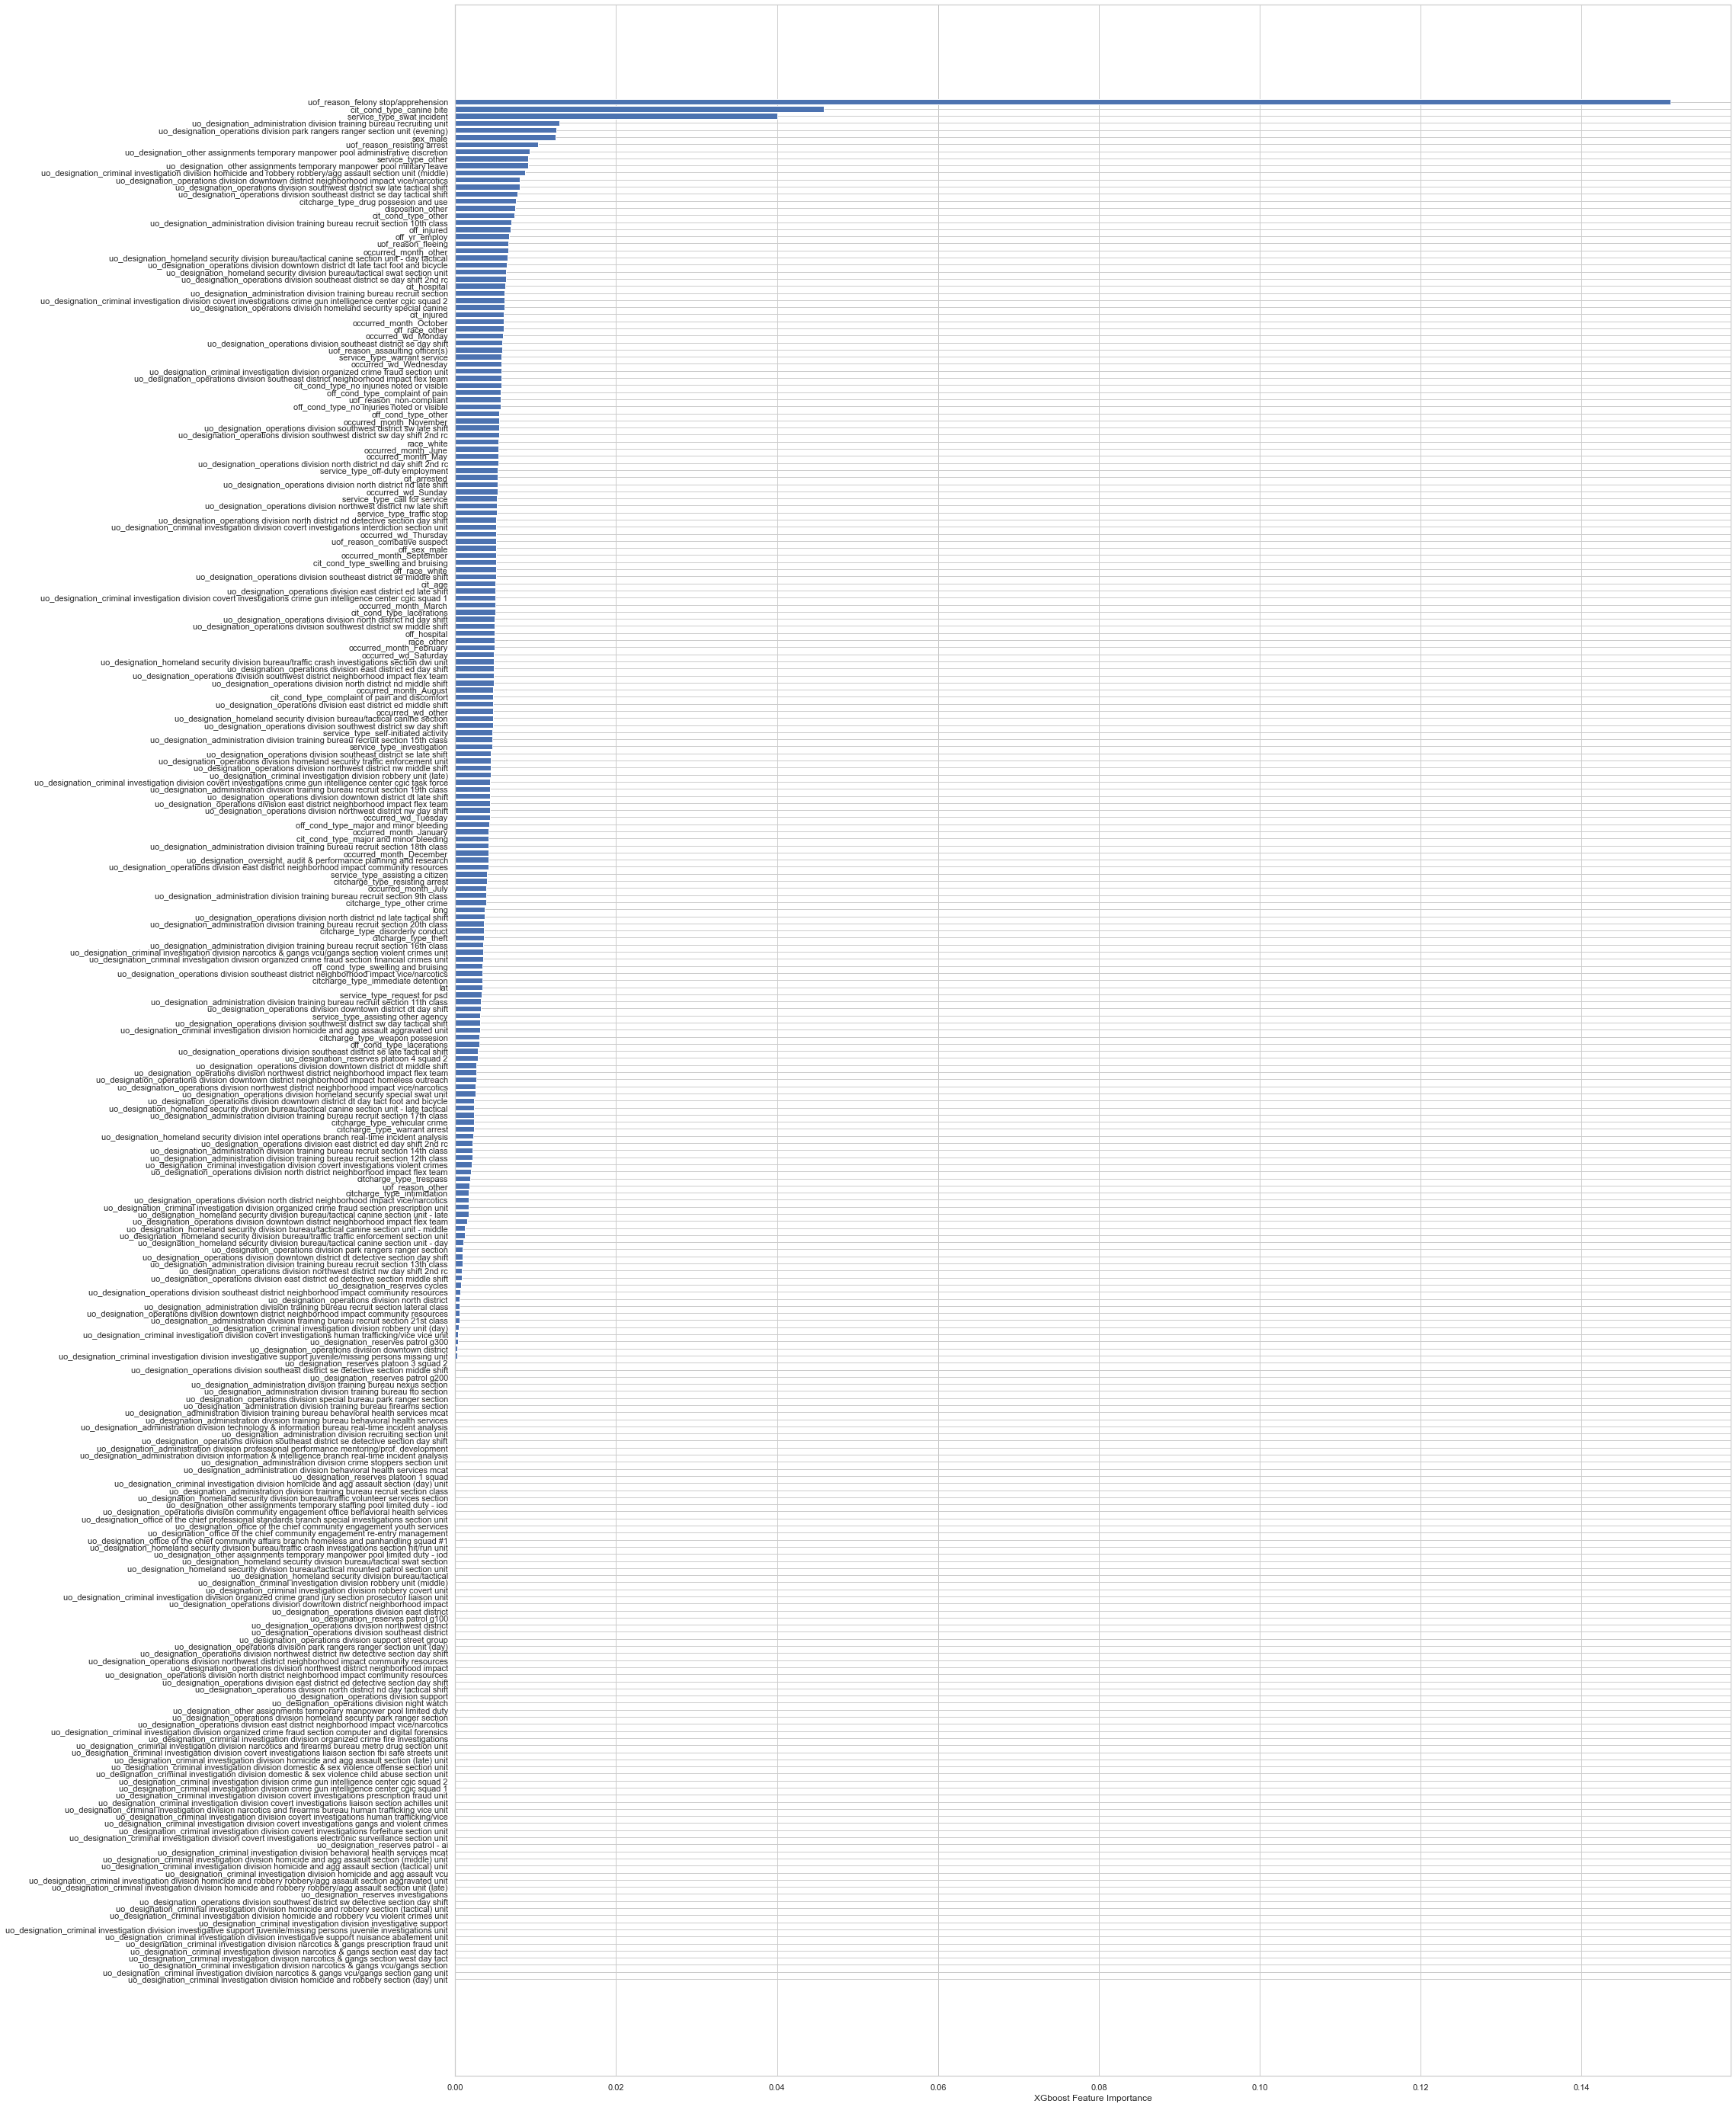

In [224]:
xgb_feature_columns = np.array(list(finalized_uof_df.columns))
xgb_sorted_idx = xgb_clf.feature_importances_.argsort()
plt.subplots(figsize=(30,50))
plt.barh(xgb_feature_columns[xgb_sorted_idx], xgb_clf.feature_importances_[xgb_sorted_idx])
plt.xlabel("XGboost Feature Importance")

Now, let's see how this model weighed certain features. Looking at the chart above I see that 3 features had a bigger impact on the model. These features were a felony stop, canine bite, and swat incidents. Other features that also played and imortant role were the poice units responsible for training new recruits, park rangers division of the IMPD, if the civilian was male and if they were resisting arrest. The canine bite is such an interesting piece of weight, because that means that in Indianapolis many civilians are being injured by canine units. I was surprised by that and wasn't expecting that to weigh so heavily on the model. This insight also brings up even more questions 

## Looking Ahead

This dataset raised some interesting questions and ideas that I would like to explore in the futrue:
* Why are there many canine attacks from canine unit?
* Why did use of force by park rangers weigh so heavily in my model?
* What significance do felony stops have when it comes to use of force?
* Why does the training and recruiting designation of the IMPD have such a large impact on the model?